<p style="font-family: Arial; font-size:3.5em;color:purple; font-style:bold"><br>
'Kr DST' Study</p><br>

# Reads an analysis DST from FLEX data and plots resolution and others

In [1]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [2]:
# General importings
import os
import sys
import glob
import logging
import math
import numpy  as np
import warnings
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors

# Specific IC stuff
import invisible_cities.core.system_of_units  as units

from invisible_cities.io.mcinfo_io import load_mcconfiguration
from invisible_cities.io.mcinfo_io import load_mcparticles_df
from invisible_cities.io.mcinfo_io import load_mchits_df
from invisible_cities.io.mcinfo_io import load_mcsensor_positions
from invisible_cities.io.mcinfo_io import load_mcsensor_response_df
from invisible_cities.io.mcinfo_io import get_sensor_types
from invisible_cities.io.mcinfo_io import get_sensor_binning
from invisible_cities.io.mcinfo_io import get_event_numbers_in_file
from invisible_cities.core.core_functions import in_range


In [3]:
from nextflex.core import Setup

In [4]:
from nextflex.krypton_dst import get_evt_true_positions_and_energy
from nextflex.krypton_dst import NN

In [5]:
from nextflex.krypton_analysis import histo1d
from nextflex.krypton_analysis import histo_df
from nextflex.krypton_analysis import histos_df
from nextflex.krypton_analysis import kr_point_resolution
from nextflex.krypton_analysis import kr_point_resolution2
from nextflex.krypton_analysis import q_sipm
from nextflex.krypton_analysis import  q4_sipm

In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [7]:
plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"     ] = 14

## Study of TP response

Common to all configurations:

- 60 PMTs, QE included
- Hamamatsu SiPMs, 1.3 x 1.3 mm2
- TP at 15 mm from anode



In [8]:
FDATA = os.environ['FLEXDATA']
print(f'path to data ={FDATA}')

path to data =/Users/jj/Development/flexdata


In [9]:
ofile_path = f"{FDATA}/kdsts"
print(f"Path to ofile = {ofile_path}")

Path to ofile = /Users/jj/Development/flexdata/kdsts


## FLEX100_M6_O6 configuration

- Assumes masks of 6 cm height and 6 cm hole



### Ideal case: 

- SiPM PDE = 1
- mask PDE = 1 (no teflon membranes)
- qTh      = 0 (no cutoff in SiPMs)

In [10]:
setup = Setup(sipmPDE    = 1.0,
              maskPDE    = 1.0,
              qTh        = 0.0,
              tpConfig   = "FLEX100_M6_O6")

In [11]:
print(f'configuration name = {setup.name}')

configuration name = FLEX100_M6_O6_PMTs_sipmPDE_1.0_maskPDE_1.0_qTh_0.0


In [12]:
ofile_name = f"{setup.name}.csv"
ofile = f"{ofile_path}/{ofile_name}"
print(f" dst name = {ofile}")

 dst name = /Users/jj/Development/flexdata/kdsts/FLEX100_M6_O6_PMTs_sipmPDE_1.0_maskPDE_1.0_qTh_0.0.csv


In [13]:
krdst1 = pd.read_csv(ofile)

In [14]:
krdst1.head()

,Unnamed: 0,event_id,true_x,true_y,true_z,KE,S1e,S2e,xMax,yMax,...,Qtot,qMax,qL,qR,qU,qD,dxPos,dyPos,dxMax,dyMax
0,0,104500,-290.29938,283.587830,1175.99710,53.914030,29,7991,-295.45,279.90,...,754.0,49.0,27.0,39.0,39.0,27.0,3.528021,2.065224,5.150623,3.687830
1,1,104501,419.13837,-0.582073,829.08356,41.543297,21,8009,419.85,0.00,...,798.0,70.0,27.0,38.0,31.0,48.0,-1.978673,1.192088,-0.711633,-0.582073
2,2,104502,157.88066,247.045960,425.46478,41.543297,17,8333,155.50,248.80,...,786.0,74.0,26.0,40.0,25.0,45.0,0.825661,0.405680,2.380661,-1.754041
3,3,104503,-222.69101,-203.131680,920.13570,41.543297,19,8602,-233.25,-202.15,...,758.0,48.0,6.0,41.0,23.0,42.0,4.830043,1.632915,10.558990,-0.981683
4,4,104504,-206.55797,-150.945130,111.76873,53.873820,15,8476,-202.15,-155.50,...,781.0,80.0,52.0,28.0,49.0,15.0,-2.075471,0.883343,-4.407968,4.554871


In [15]:
krdst1.columns

Index(['Unnamed: 0', 'event_id', 'true_x', 'true_y', 'true_z', 'KE', 'S1e',
       'S2e', 'xMax', 'yMax', 'xPos', 'yPos', 'rPos', 'Qtot', 'qMax', 'qL',
       'qR', 'qU', 'qD', 'dxPos', 'dyPos', 'dxMax', 'dyMax'],
      dtype='object')

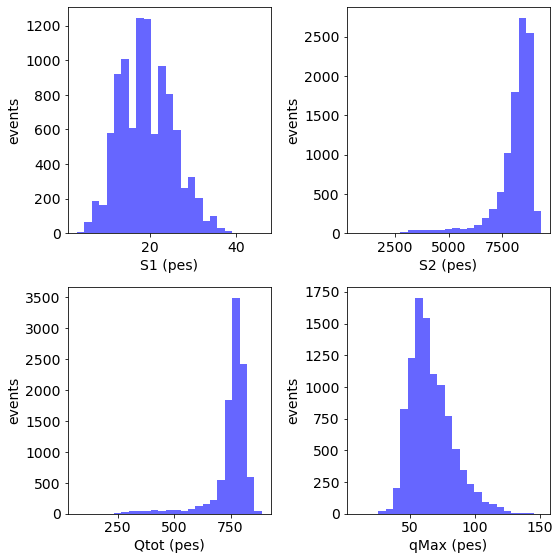

In [19]:
histos_df(krdst1, 
          vars    = ('S1e','S2e','Qtot','qMax'), 
          varmins = [0,0,0, 0], 
          varmaxs = [50,10000,1000,200], 
          xlabels = ['S1 (pes)','S2 (pes)','Qtot (pes)','qMax (pes)'], 
          ylabels = 4 * ['events'], 
          bins    = 4 * [25],
          alphas  = 4 * [0.6],
          colors  = 4 * ['b'],
          splt    = (2,2), 
          figsize = (8,8))

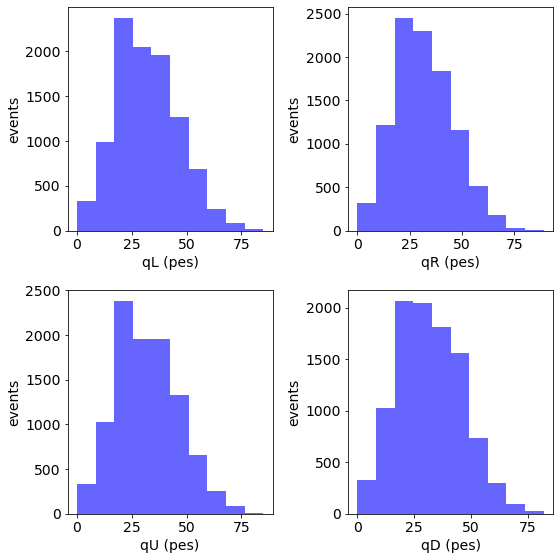

In [20]:
histos_df(krdst1, 
          vars    = ('qL','qR','qU','qD'), 
          varmins = 4 * [0], 
          varmaxs = 4 * [100], 
          xlabels = ['qL (pes)','qR (pes)','qU (pes)','qD (pes)'], 
          ylabels = 4 * ['events'], 
          bins    = 4 * [10],
          alphas  = 4 * [0.6],
          colors  = 4 * ['b'],
          splt    = (2,2), 
          figsize = (8,8))

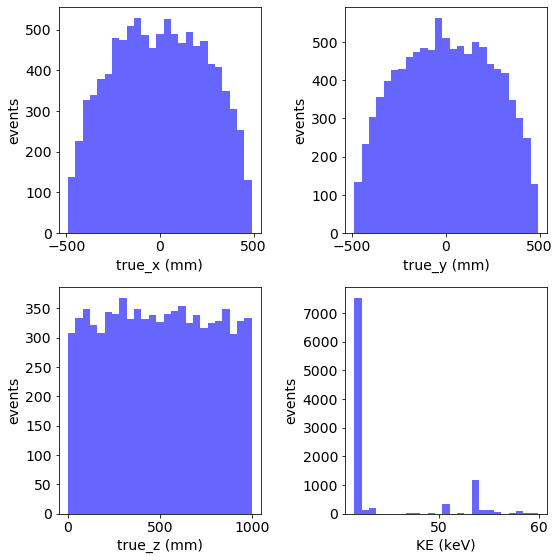

In [21]:
histos_df(krdst1, 
          vars    = ('true_x','true_y','true_z','KE'), 
          varmins = [-500,-500,-500, 30], 
          varmaxs = [500,500,1000,60], 
          xlabels = ['true_x (mm)','true_y (mm)','true_z (mm)','KE (keV)'], 
          ylabels = 4 * ['events'], 
          bins    = 4 * [25],
          alphas  = 4 * [0.6],
          colors  = 4 * ['b'],
          splt    = (2,2), 
          figsize = (8,8))

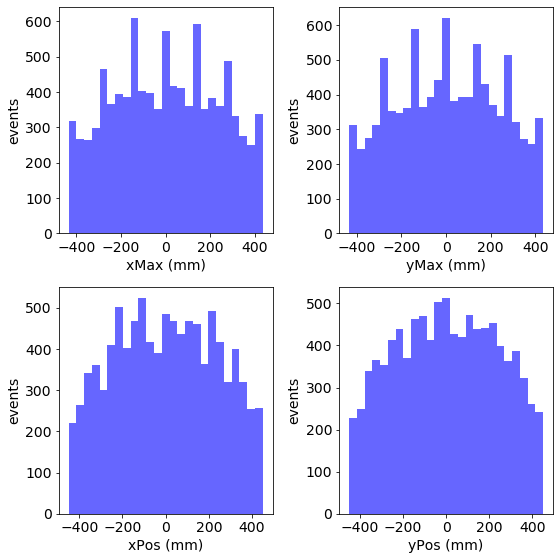

In [22]:
histos_df(krdst1, 
          vars    = ('xMax','yMax','xPos','yPos'), 
          varmins = 4 * [-450], 
          varmaxs = 4 * [450], 
          xlabels = ['xMax (mm)','yMax (mm)','xPos (mm)','yPos (mm)'], 
          ylabels = 4 * ['events'], 
          bins    = 4 * [25],
          alphas  = 4 * [0.6],
          colors  = 4 * ['b'],
          splt    = (2,2), 
          figsize = (8,8))

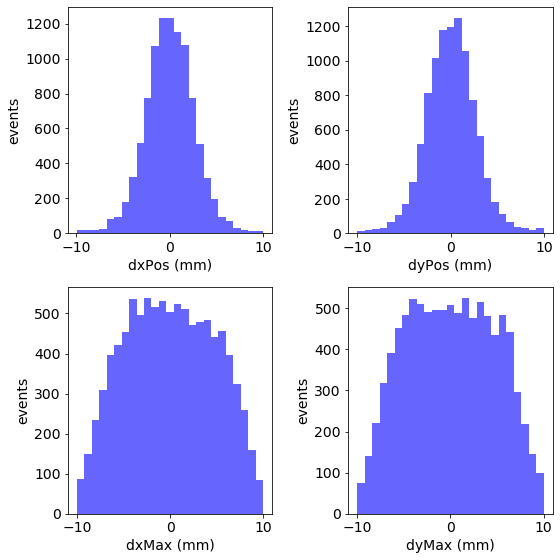

In [23]:
histos_df(krdst1, 
          vars    = ('dxPos','dyPos','dxMax','dyMax'), 
          varmins = 4 * [-10], 
          varmaxs = 4 * [10], 
          xlabels = ['dxPos (mm)','dyPos (mm)','dxMax (mm)','dyMax (mm)'], 
          ylabels = 4 * ['events'], 
          bins    = 4 * [25],
          alphas  = 4 * [0.6],
          colors  = 4 * ['b'],
          splt    = (2,2), 
          figsize = (8,8))

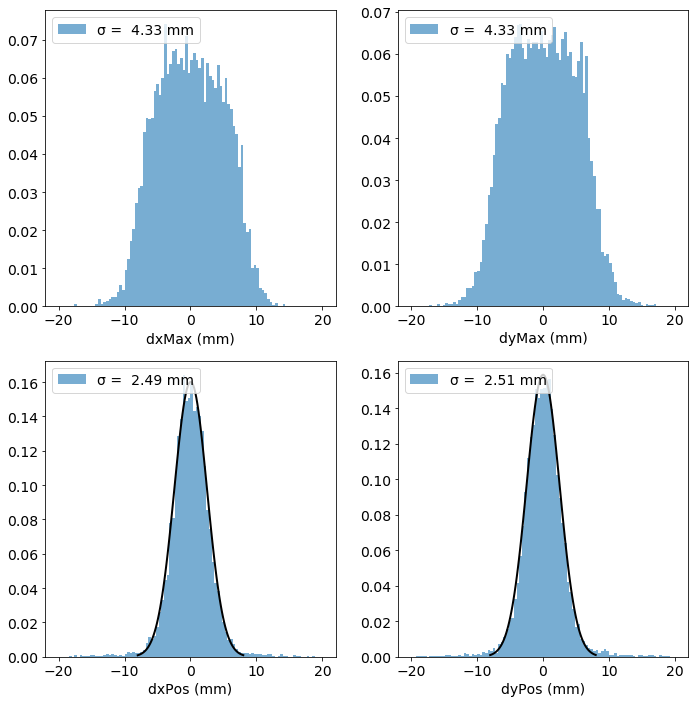

In [24]:
kr_point_resolution2(krdst1, xlim=(-8,8), bins=100, figsize=(10,10))

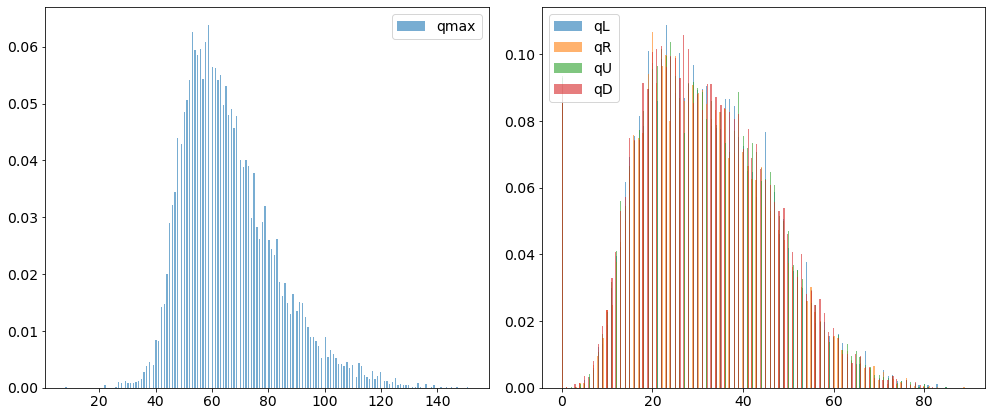

In [25]:
q_sipm(krdst1,  bins=300, figsize=(14,6), alpha=0.6)

In [30]:
krdst = krdst1[np.sqrt(krdst1.true_x**2 + krdst1.true_y**2) < 400]

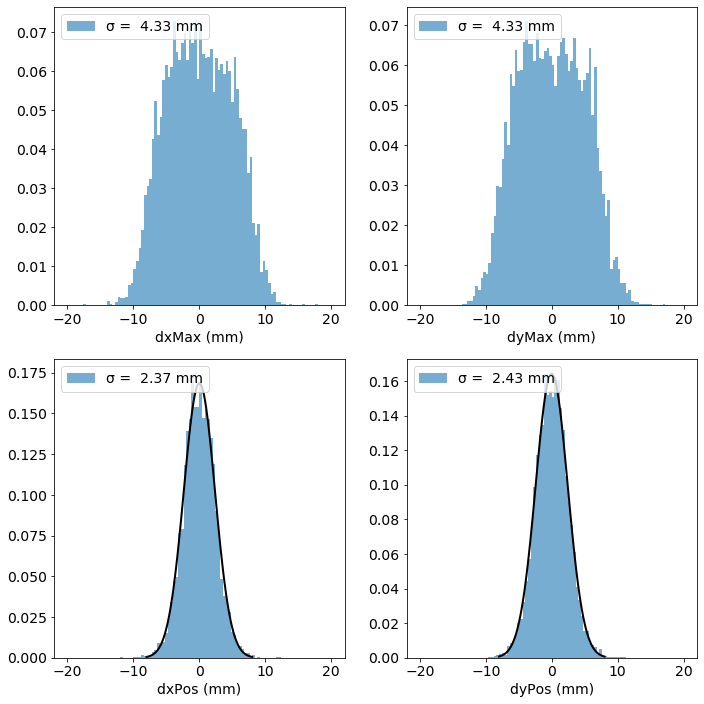

In [31]:
kr_point_resolution2(krdst, xlim=(-8,8), bins=100, figsize=(10,10))

#### Summary:

- qMax peaks at 60 pes, while qL,qR,qR,qU,qD are about 30 pes, which is quite optimal for baricenter estimation. 
- Baricenter resolution is 2.5 mmm to be compared with digital resolution (4.3 mm).

### sipmPDE = 0.4

In [82]:
setup = Setup(sipmPDE    = 0.4,
              maskPDE    = 1.0,
              qTh        = 0.0,
              tpConfig   = "FLEX100_M6_O6")
ofile_name = f"{setup.name}.csv"
ofile = f"{ofile_path}/{ofile_name}"
print(f" dst name = {ofile}")

 dst name = /Users/jj/Development/flexdata/kdsts/FLEX100_M6_O6_PMTs_sipmPDE_0.4_maskPDE_1.0_qTh_0.0.csv


In [83]:
krdst2 = pd.read_csv(ofile)

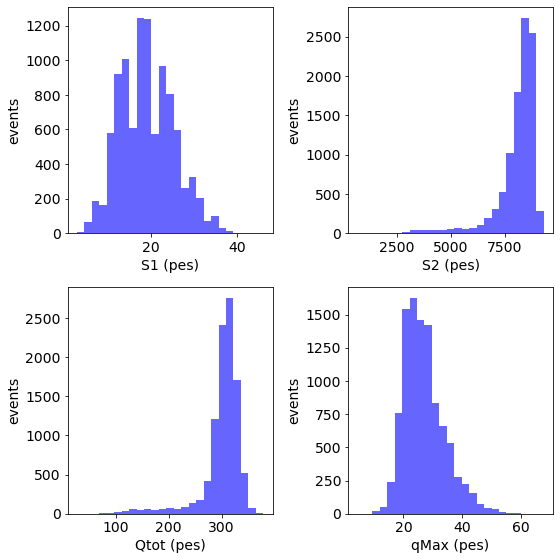

In [84]:
histos_df(krdst2, 
          vars    = ('S1e','S2e','Qtot','qMax'), 
          varmins = [0,0,0, 0], 
          varmaxs = [50,10000,1000,200], 
          xlabels = ['S1 (pes)','S2 (pes)','Qtot (pes)','qMax (pes)'], 
          ylabels = 4 * ['events'], 
          bins    = 4 * [25],
          alphas  = 4 * [0.6],
          colors  = 4 * ['b'],
          splt    = (2,2), 
          figsize = (8,8))

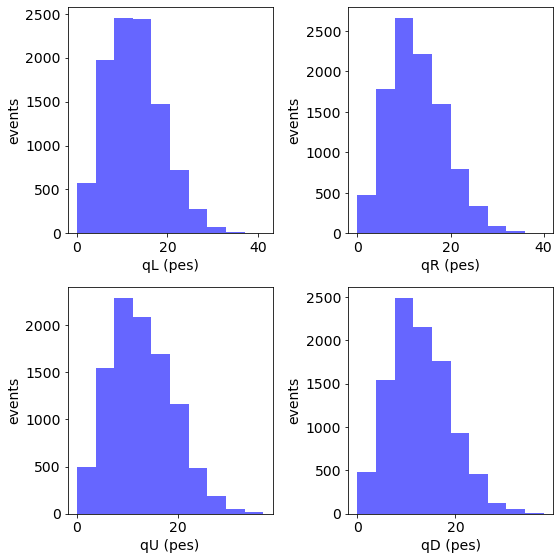

In [85]:
histos_df(krdst2, 
          vars    = ('qL','qR','qU','qD'), 
          varmins = 4 * [0], 
          varmaxs = 4 * [100], 
          xlabels = ['qL (pes)','qR (pes)','qU (pes)','qD (pes)'], 
          ylabels = 4 * ['events'], 
          bins    = 4 * [10],
          alphas  = 4 * [0.6],
          colors  = 4 * ['b'],
          splt    = (2,2), 
          figsize = (8,8))

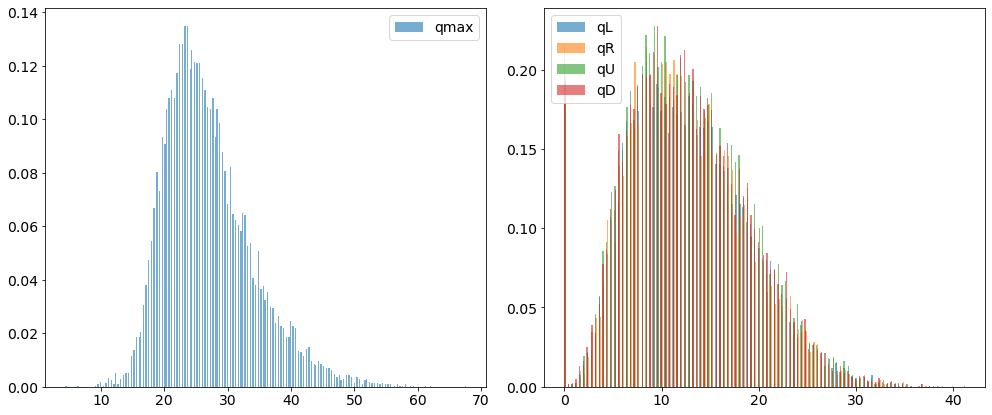

In [86]:
q_sipm(krdst2,  bins=300, figsize=(14,6), alpha=0.6)

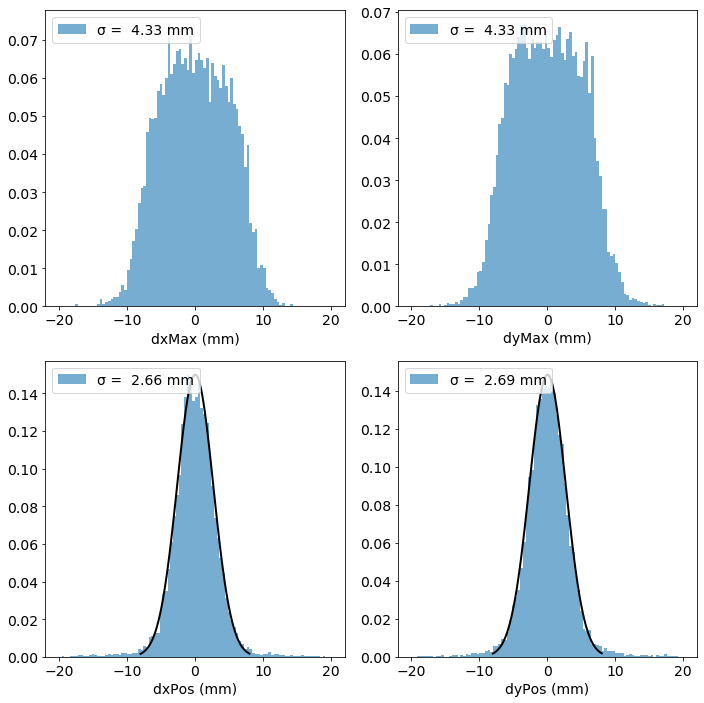

In [88]:
kr_point_resolution2(krdst2, xlim=(-8,8), bins=100, figsize=(10,10))

#### Resolution deteriorates but not too much (2.7 mm)

### SiPM PDE = 0.5, Threshold = 1 pes 

In [89]:
setup = Setup(sipmPDE    = 0.5,
              maskPDE    = 1.0,
              qTh        = 1.0,
              tpConfig   = "FLEX100_M6_O6")
ofile_name = f"{setup.name}.csv"
ofile = f"{ofile_path}/{ofile_name}"
print(f" dst name = {ofile}")

 dst name = /Users/jj/Development/flexdata/kdsts/FLEX100_M6_O6_PMTs_sipmPDE_0.5_maskPDE_1.0_qTh_1.0.csv


In [90]:
krdst3 = pd.read_csv(ofile)

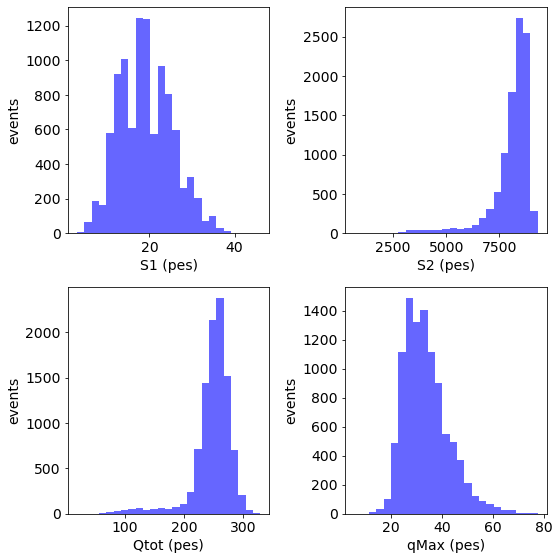

In [91]:
histos_df(krdst3, 
          vars    = ('S1e','S2e','Qtot','qMax'), 
          varmins = [0,0,0, 0], 
          varmaxs = [50,10000,1000,200], 
          xlabels = ['S1 (pes)','S2 (pes)','Qtot (pes)','qMax (pes)'], 
          ylabels = 4 * ['events'], 
          bins    = 4 * [25],
          alphas  = 4 * [0.6],
          colors  = 4 * ['b'],
          splt    = (2,2), 
          figsize = (8,8))

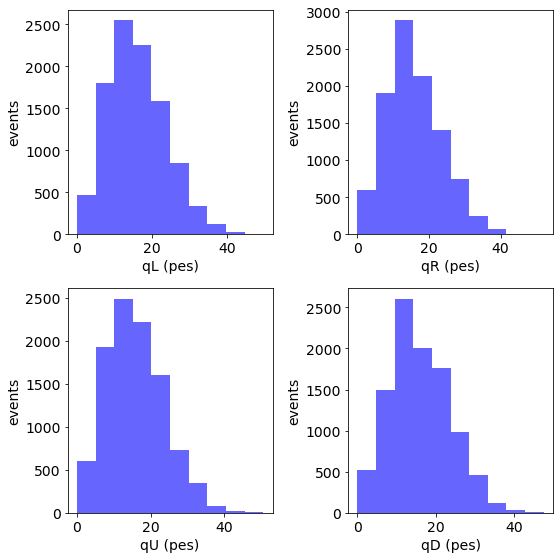

In [92]:
histos_df(krdst3, 
          vars    = ('qL','qR','qU','qD'), 
          varmins = 4 * [0], 
          varmaxs = 4 * [100], 
          xlabels = ['qL (pes)','qR (pes)','qU (pes)','qD (pes)'], 
          ylabels = 4 * ['events'], 
          bins    = 4 * [10],
          alphas  = 4 * [0.6],
          colors  = 4 * ['b'],
          splt    = (2,2), 
          figsize = (8,8))

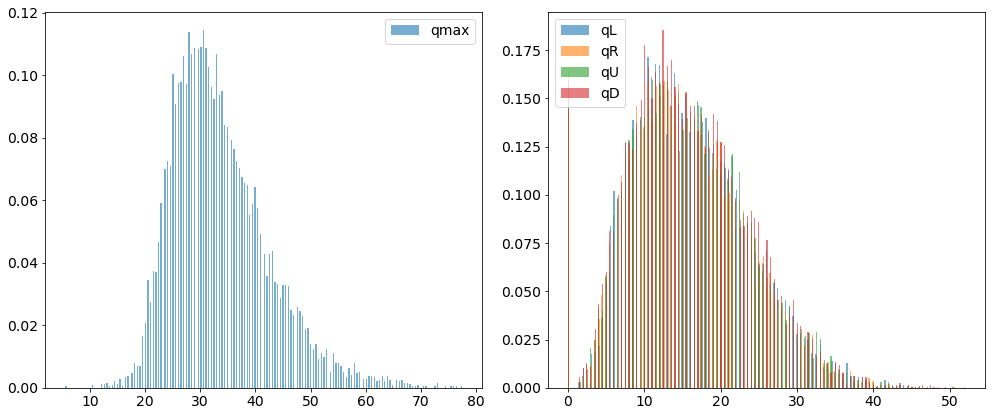

In [93]:
q_sipm(krdst3,  bins=300, figsize=(14,6), alpha=0.6)

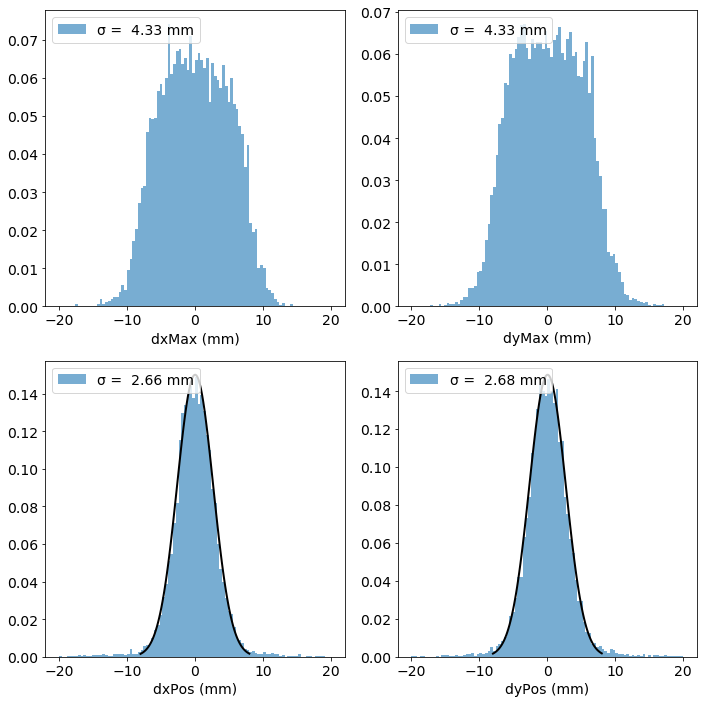

In [94]:
kr_point_resolution2(krdst3, xlim=(-8,8), bins=100, figsize=(10,10))

#### Cutoff at 1 pes does not have an impact on resolution

### SiPM PDE = 0.5, Threshold = 5 pes

In [95]:
setup = Setup(sipmPDE    = 0.5,
              maskPDE    = 1.0,
              qTh        = 5.0,
              tpConfig   = "FLEX100_M6_O6")
ofile_name = f"{setup.name}.csv"
ofile = f"{ofile_path}/{ofile_name}"
print(f" dst name = {ofile}")

 dst name = /Users/jj/Development/flexdata/kdsts/FLEX100_M6_O6_PMTs_sipmPDE_0.5_maskPDE_1.0_qTh_5.0.csv


In [96]:
krdst4 = pd.read_csv(ofile)

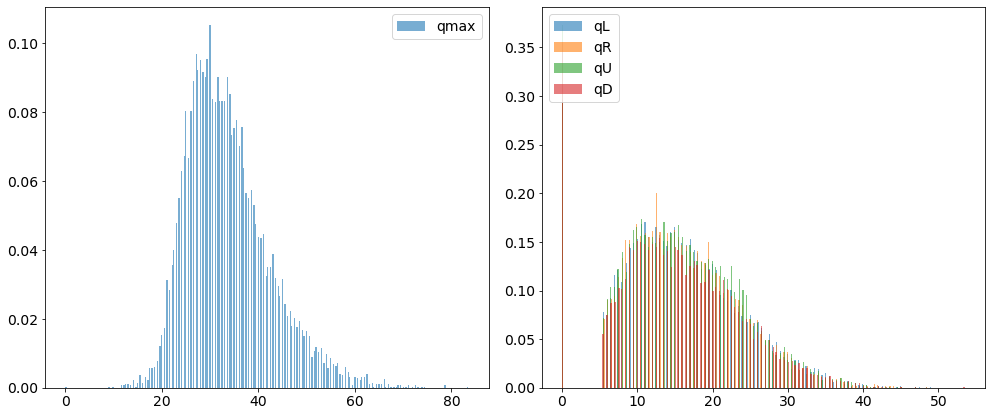

In [97]:
q_sipm(krdst4,  bins=300, figsize=(14,6), alpha=0.6)

/Users/jj/miniconda3/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jj/miniconda3/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Users/jj/miniconda3/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jj/miniconda3/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


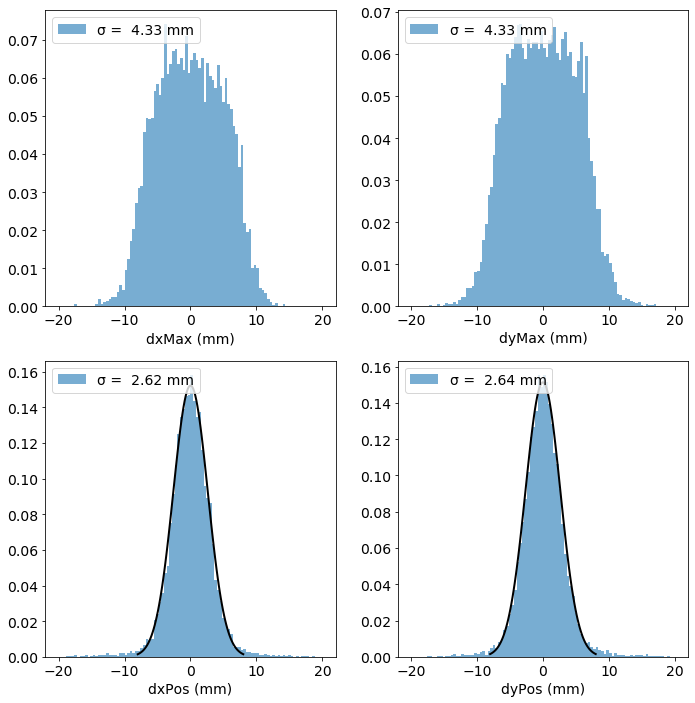

In [106]:
kr_point_resolution2(krdst4, xlim=(-8,8), bins=100, figsize=(10,10))

#### Resolution still OK 

### SiPM PDE = 0.4, Threshold = 5 pes, maskPDE = 0.4

In [107]:
setup = Setup(sipmPDE    = 0.4,
              maskPDE    = 0.4,
              qTh        = 5.0,
              tpConfig   = "FLEX100_M6_O6")
ofile_name = f"{setup.name}.csv"
ofile = f"{ofile_path}/{ofile_name}"
print(f" dst name = {ofile}")

 dst name = /Users/jj/Development/flexdata/kdsts/FLEX100_M6_O6_PMTs_sipmPDE_0.4_maskPDE_0.4_qTh_5.0.csv


In [108]:
krdst5 = pd.read_csv(ofile)

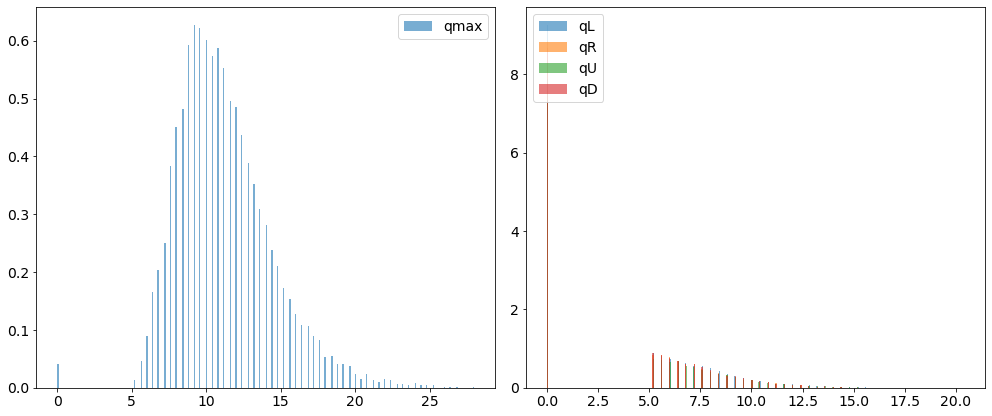

In [109]:
q_sipm(krdst5,  bins=300, figsize=(14,6), alpha=0.6)

/Users/jj/miniconda3/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jj/miniconda3/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Users/jj/miniconda3/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jj/miniconda3/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


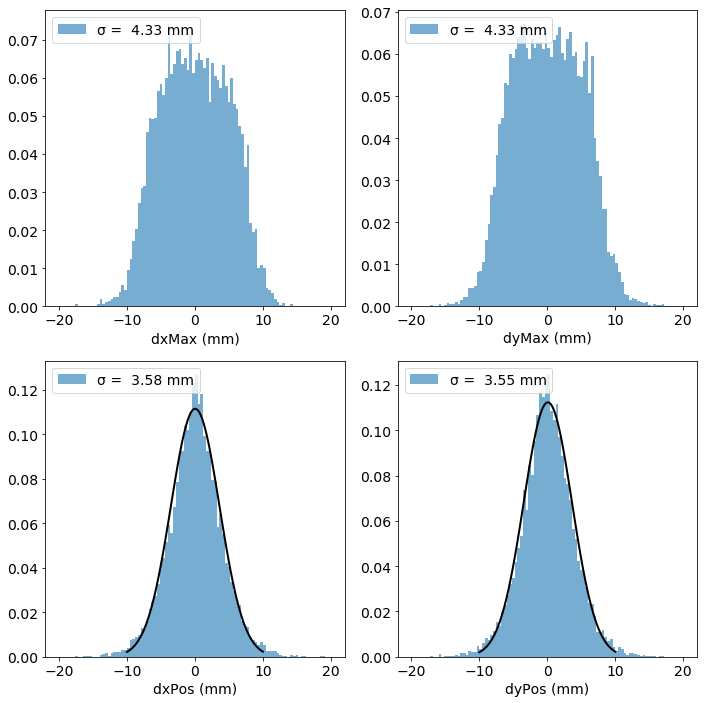

In [111]:
kr_point_resolution2(krdst5, xlim=(-10,10), bins=100, figsize=(10,10))

#### Resolution spoiled

### SiPM PDE = 0.4, Threshold = 1 pes, maskPDE = 0.4

In [112]:
setup = Setup(sipmPDE    = 0.4,
              maskPDE    = 0.4,
              qTh        = 1.0,
              tpConfig   = "FLEX100_M6_O6")
ofile_name = f"{setup.name}.csv"
ofile = f"{ofile_path}/{ofile_name}"
print(f" dst name = {ofile}")

 dst name = /Users/jj/Development/flexdata/kdsts/FLEX100_M6_O6_PMTs_sipmPDE_0.4_maskPDE_0.4_qTh_1.0.csv


In [114]:
krdst6 = pd.read_csv(ofile)

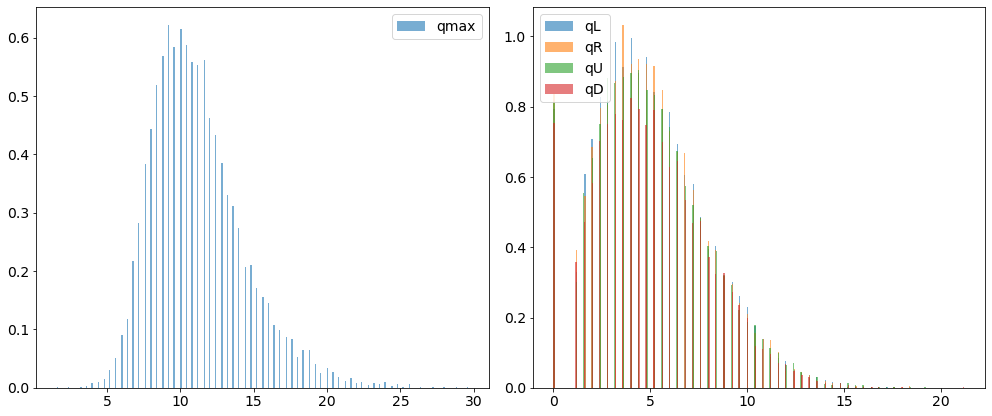

In [115]:
q_sipm(krdst6,  bins=300, figsize=(14,6), alpha=0.6)

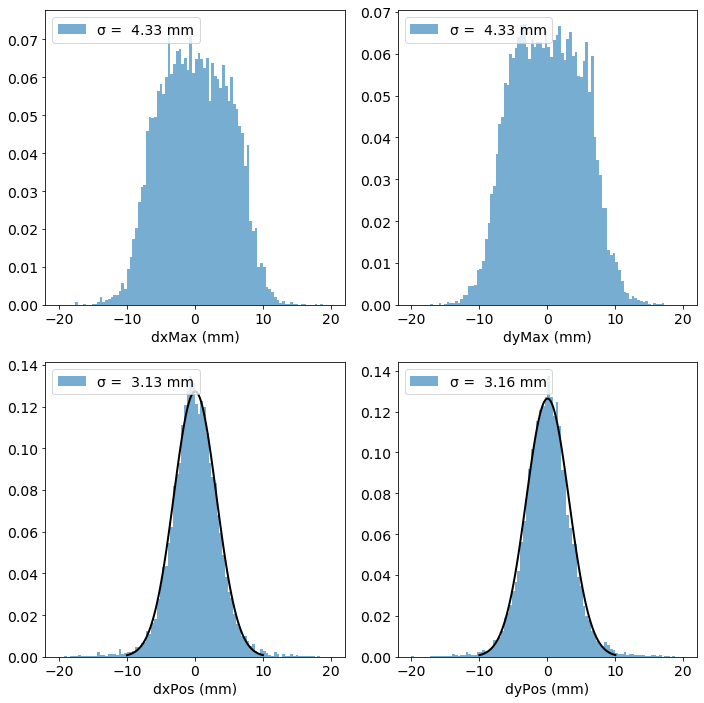

In [116]:
kr_point_resolution2(krdst6, xlim=(-10,10), bins=100, figsize=(10,10))

#### Effect of masks deteriorates resolution

## FLEX100_M6_O6_EL8bar configuration

- Increases the EL amplification according to 8 bar formula


### Nominal (best) resolution

In [117]:
setup = Setup(sipmPDE    = 1.0,
              maskPDE    = 1.0,
              qTh        = 0.0,
              tpConfig   = "FLEX100_M6_O6_EL8bar")
ofile_name = f"{setup.name}.csv"
ofile = f"{ofile_path}/{ofile_name}"
print(f" dst name = {ofile}")

 dst name = /Users/jj/Development/flexdata/kdsts/FLEX100_M6_O6_EL8bar_PMTs_sipmPDE_1.0_maskPDE_1.0_qTh_0.0.csv


In [118]:
krdst7 = pd.read_csv(ofile)

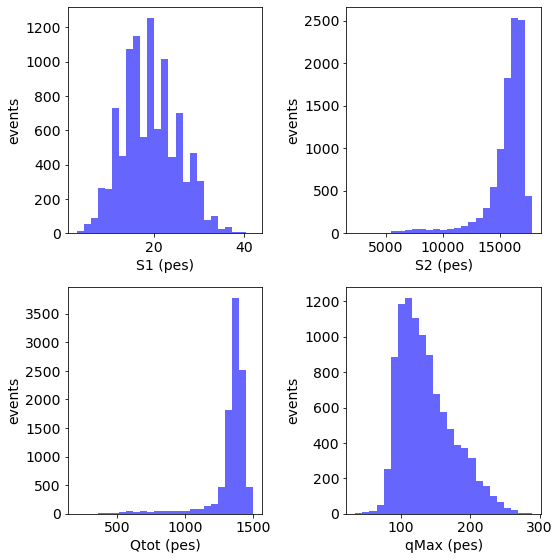

In [179]:
histos_df(krdst7, 
          vars    = ('S1e','S2e','Qtot','qMax'), 
          varmins = [0,0,0, 0], 
          varmaxs = [50,20000,1500,300], 
          xlabels = ['S1 (pes)','S2 (pes)','Qtot (pes)','qMax (pes)'], 
          ylabels = 4 * ['events'], 
          bins    = 4 * [25],
          alphas  = 4 * [0.6],
          colors  = 4 * ['b'],
          splt    = (2,2), 
          figsize = (8,8))

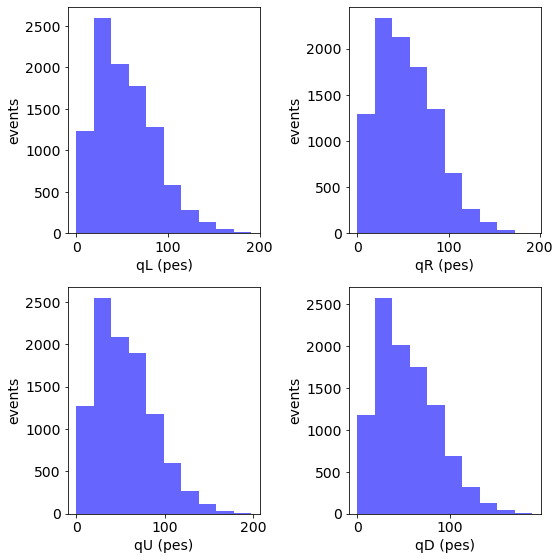

In [181]:
histos_df(krdst7, 
          vars    = ('qL','qR','qU','qD'), 
          varmins = 4 * [0], 
          varmaxs = 4 * [200], 
          xlabels = ['qL (pes)','qR (pes)','qU (pes)','qD (pes)'], 
          ylabels = 4 * ['events'], 
          bins    = 4 * [10],
          alphas  = 4 * [0.6],
          colors  = 4 * ['b'],
          splt    = (2,2), 
          figsize = (8,8))

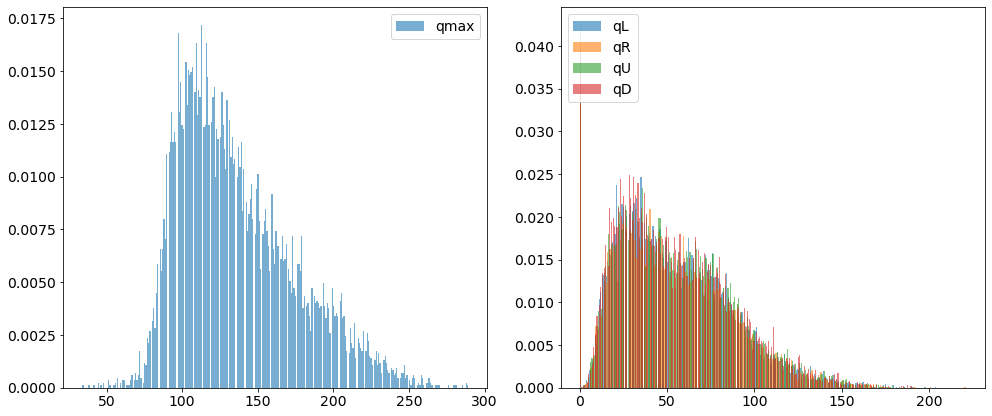

In [119]:
q_sipm(krdst7,  bins=300, figsize=(14,6), alpha=0.6)

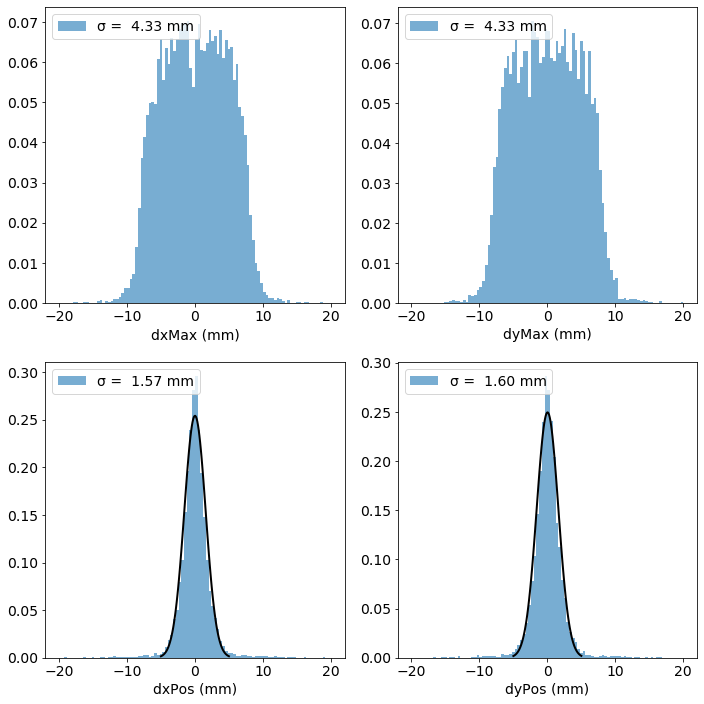

In [120]:
kr_point_resolution2(krdst7, xlim=(-5,5), bins=100, figsize=(10,10))

#### Resolution 1.6 mm

### PDE = 0.4 Th =1 pes but no maks

In [121]:
setup = Setup(sipmPDE    = 0.4,
              maskPDE    = 1.0,
              qTh        = 1.0,
              tpConfig   = "FLEX100_M6_O6_EL8bar")
ofile_name = f"{setup.name}.csv"
ofile = f"{ofile_path}/{ofile_name}"
print(f" dst name = {ofile}")

 dst name = /Users/jj/Development/flexdata/kdsts/FLEX100_M6_O6_EL8bar_PMTs_sipmPDE_0.4_maskPDE_1.0_qTh_1.0.csv


In [122]:
krdst8 = pd.read_csv(ofile)

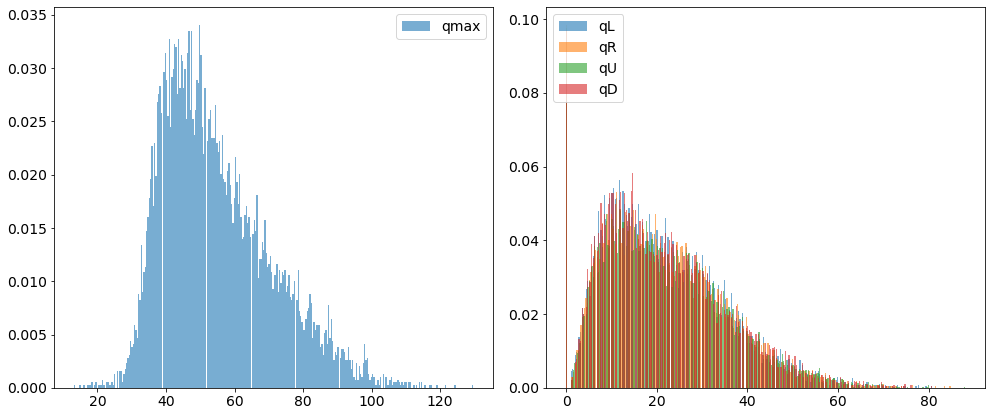

In [123]:
q_sipm(krdst8,  bins=300, figsize=(14,6), alpha=0.6)

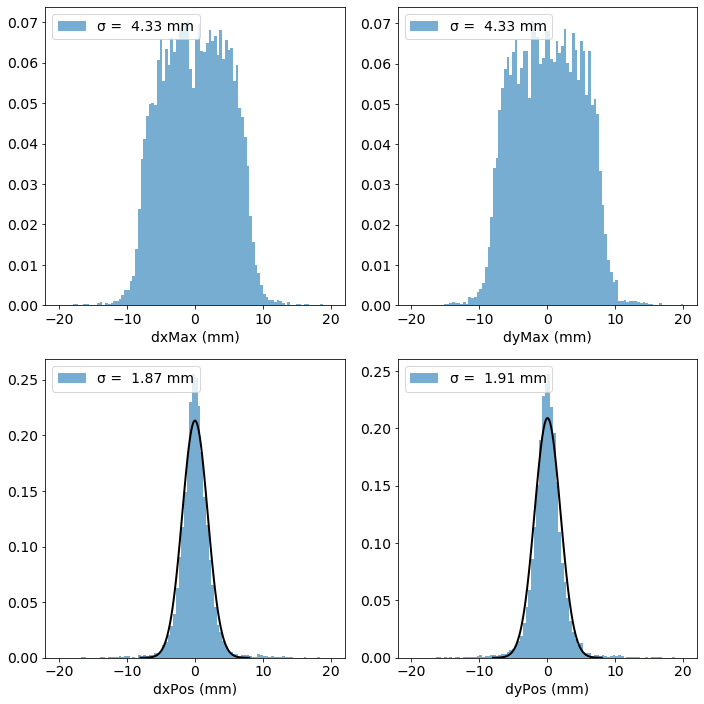

In [130]:
kr_point_resolution2(krdst8, xlim=(-8,8), bins=100, figsize=(10,10))

#### Resolution 1.9 mm

### PDE = 0.4, Th = 1 pes, masks (PDE mask = 0.4)

In [125]:
setup = Setup(sipmPDE    = 0.4,
              maskPDE    = 0.4,
              qTh        = 1.0,
              tpConfig   = "FLEX100_M6_O6_EL8bar")
ofile_name = f"{setup.name}.csv"
ofile = f"{ofile_path}/{ofile_name}"
print(f" dst name = {ofile}")

 dst name = /Users/jj/Development/flexdata/kdsts/FLEX100_M6_O6_EL8bar_PMTs_sipmPDE_0.4_maskPDE_0.4_qTh_1.0.csv


In [126]:
krdst9 = pd.read_csv(ofile)

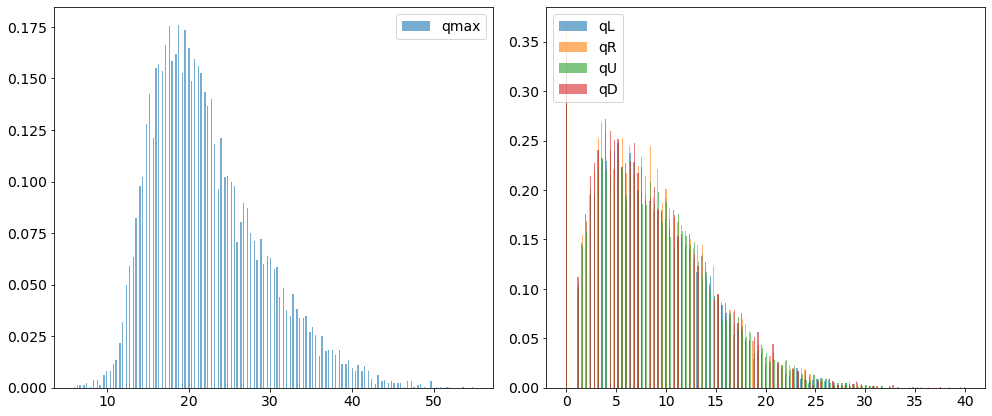

In [127]:
q_sipm(krdst9,  bins=300, figsize=(14,6), alpha=0.6)

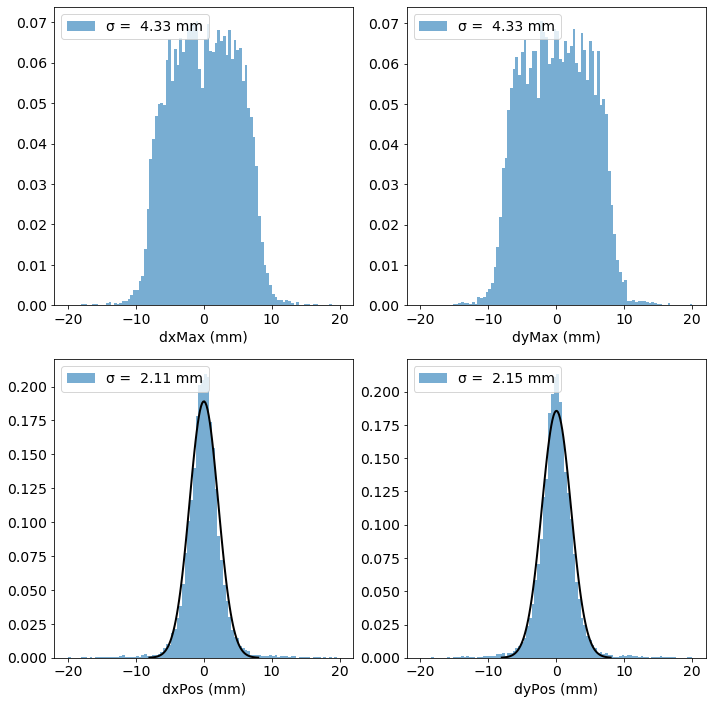

In [129]:
kr_point_resolution2(krdst9, xlim=(-8,8), bins=100, figsize=(10,10))

#### Resolution 2.1 mm

### PDE, maks, TH = 5 pes

In [131]:
setup = Setup(sipmPDE    = 0.4,
              maskPDE    = 0.4,
              qTh        = 5.0,
              tpConfig   = "FLEX100_M6_O6_EL8bar")
ofile_name = f"{setup.name}.csv"
ofile = f"{ofile_path}/{ofile_name}"
print(f" dst name = {ofile}")

 dst name = /Users/jj/Development/flexdata/kdsts/FLEX100_M6_O6_EL8bar_PMTs_sipmPDE_0.4_maskPDE_0.4_qTh_5.0.csv


In [132]:
krdst10 = pd.read_csv(ofile)

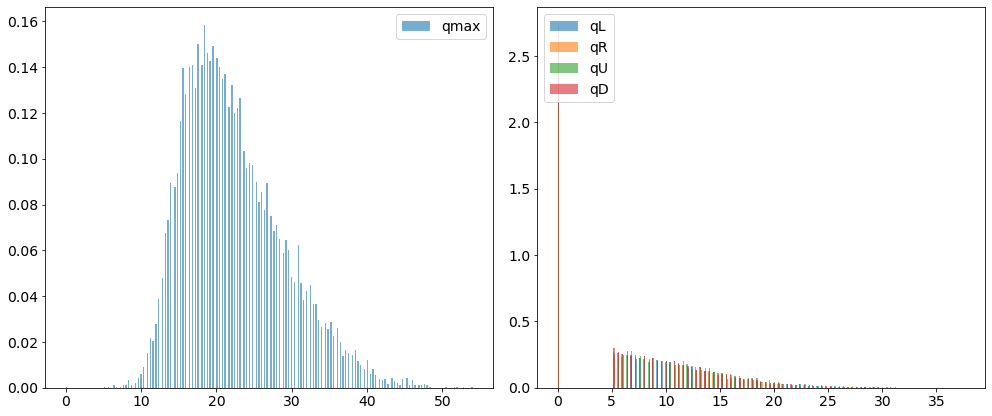

In [134]:
q_sipm(krdst10,  bins=300, figsize=(14,6), alpha=0.6)

/Users/jj/miniconda3/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jj/miniconda3/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Users/jj/miniconda3/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jj/miniconda3/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


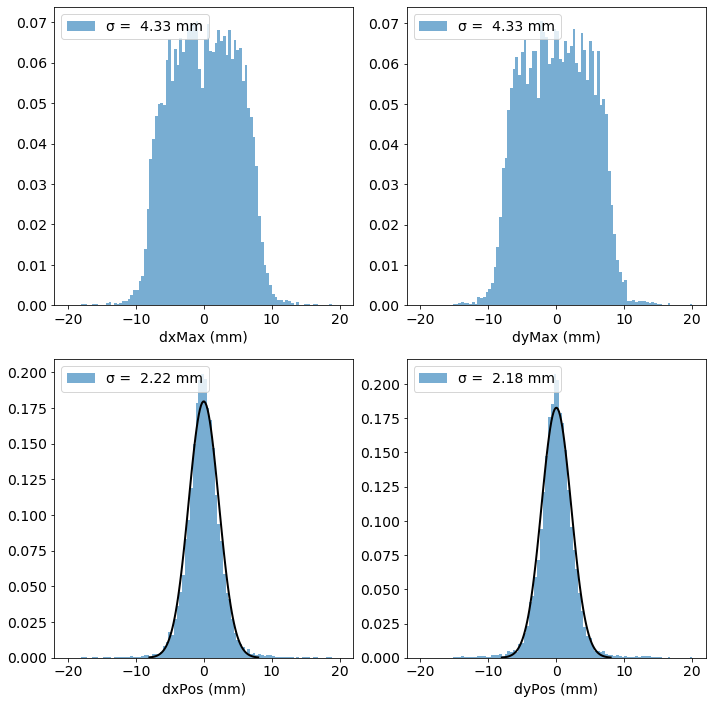

In [135]:
kr_point_resolution2(krdst10, xlim=(-8,8), bins=100, figsize=(10,10))

#### 2.2 mm

## FLEX100_M6_O6_EL8bar_memb

### Nominal 

In [151]:
setup = Setup(sipmPDE    = 1.0,
              maskPDE    = 1.0,
              qTh        = 0.0,
              tpConfig   = "FLEX100_M6_O6_EL8bar_memb")
ofile_name = f"{setup.name}.csv"
ofile = f"{ofile_path}/{ofile_name}"
print(f" dst name = {ofile}")

 dst name = /Users/jj/Development/flexdata/kdsts/FLEX100_M6_O6_EL8bar_memb_PMTs_sipmPDE_1.0_maskPDE_1.0_qTh_0.0.csv


In [152]:
krdst = pd.read_csv(ofile)

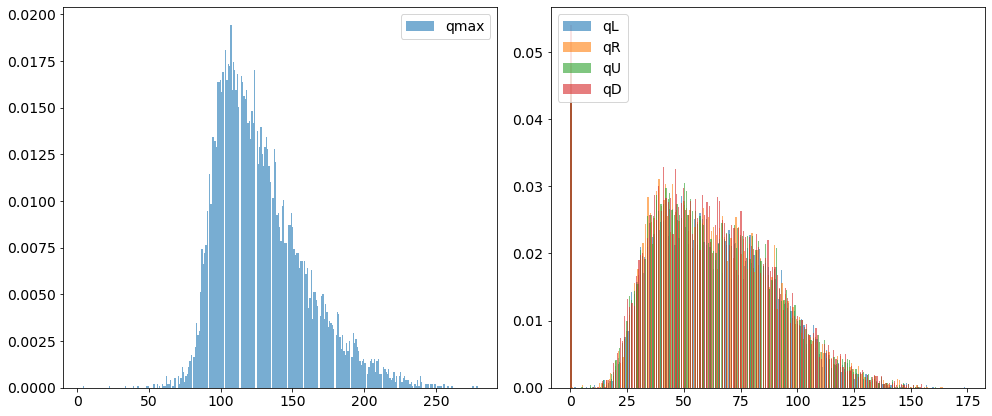

In [153]:
q_sipm(krdst,  bins=300, figsize=(14,6), alpha=0.6)

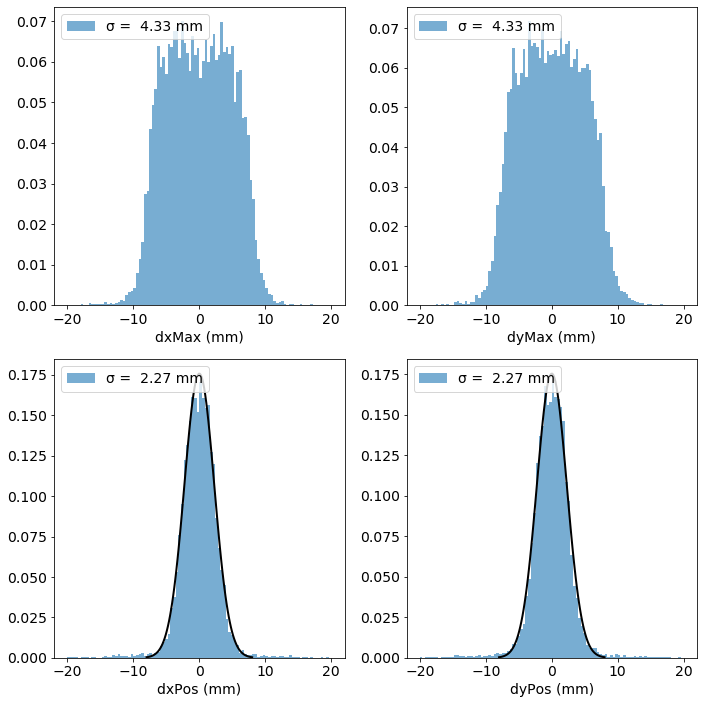

In [154]:
kr_point_resolution2(krdst, xlim=(-8,8), bins=100, figsize=(10,10))

#### The position of the membrane has en effect! Resolution changes from 1.6 to 2.3

### PDE = 0.4 PDE mask = 0.4 Th = 1 pes

In [156]:
setup = Setup(sipmPDE    = 0.4,
              maskPDE    = 0.4,
              qTh        = 1.0,
              tpConfig   = "FLEX100_M6_O6_EL8bar_memb")
ofile_name = f"{setup.name}.csv"
ofile = f"{ofile_path}/{ofile_name}"
print(f" dst name = {ofile}")
krdst = pd.read_csv(ofile)

 dst name = /Users/jj/Development/flexdata/kdsts/FLEX100_M6_O6_EL8bar_memb_PMTs_sipmPDE_0.4_maskPDE_0.4_qTh_1.0.csv


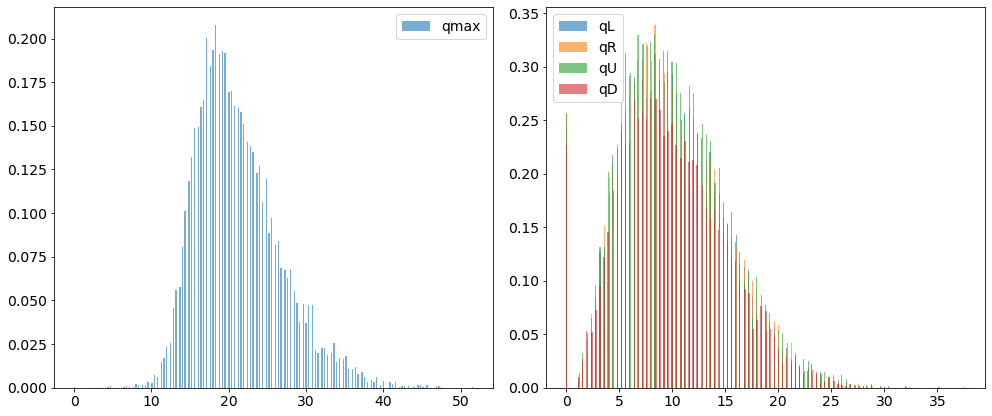

/Users/jj/miniconda3/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jj/miniconda3/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Users/jj/miniconda3/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jj/miniconda3/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


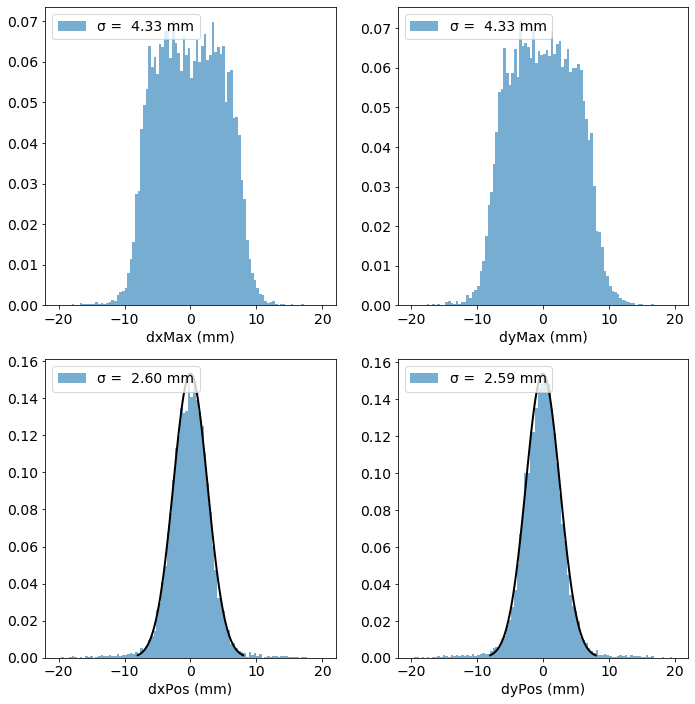

In [157]:
q_sipm(krdst,  bins=300, figsize=(14,6), alpha=0.6)
kr_point_resolution2(krdst, xlim=(-8,8), bins=100, figsize=(10,10))

### Membranes, PDE = 0.4, PDE mask = 0.4, Th = 5 pes 

In [158]:
setup = Setup(sipmPDE    = 0.4,
              maskPDE    = 0.4,
              qTh        = 5.0,
              tpConfig   = "FLEX100_M6_O6_EL8bar_memb")
ofile_name = f"{setup.name}.csv"
ofile = f"{ofile_path}/{ofile_name}"
print(f" dst name = {ofile}")
krdst = pd.read_csv(ofile)

 dst name = /Users/jj/Development/flexdata/kdsts/FLEX100_M6_O6_EL8bar_memb_PMTs_sipmPDE_0.4_maskPDE_0.4_qTh_5.0.csv


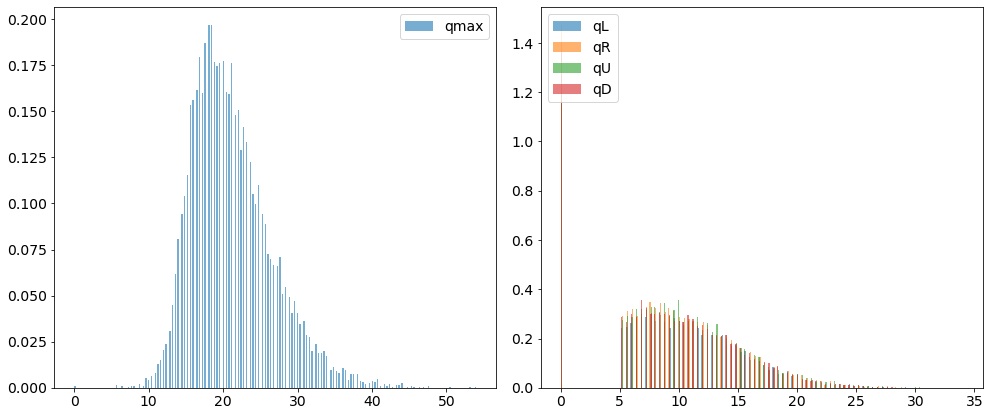

/Users/jj/miniconda3/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jj/miniconda3/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Users/jj/miniconda3/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jj/miniconda3/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


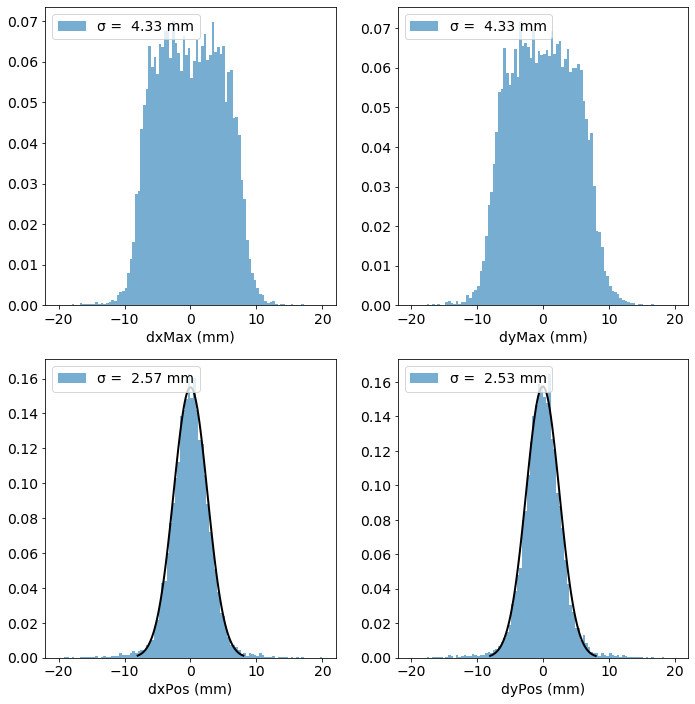

In [159]:
q_sipm(krdst,  bins=300, figsize=(14,6), alpha=0.6)
kr_point_resolution2(krdst, xlim=(-8,8), bins=100, figsize=(10,10))

#### resolution 2.6 mm against 1.9 mm

## Membranes?

- Membranes introduce an additional PDE that spoils resolution. 
- If membrane is in back plane (near the SiPM): 1.9 -> 2.1 mm
- If membrane is in top plane (near anode) : 1.9 -> 2.6 mm
- Performance in both cases seem to hold irrespectively of cut at 5 pes. This is due to the fact that there is enough light for the cluster around SiPM max Q to have charge enough times. 

- In conclussion, membranes could be used with a tolerable loos of resolution, if near SiPMs (bottom membrane) but resolution is further spoiled if used near anode (top membrane).

- Best results achieved without membranes

## FLEX100_M8_O6_EL8bar

### Nominal

In [160]:
setup = Setup(sipmPDE    = 1.0,
              maskPDE    = 1.0,
              qTh        = 0.0,
              tpConfig   = "FLEX100_M8_O6_EL8bar")
ofile_name = f"{setup.name}.csv"
ofile = f"{ofile_path}/{ofile_name}"
print(f" dst name = {ofile}")
krdst = pd.read_csv(ofile)

 dst name = /Users/jj/Development/flexdata/kdsts/FLEX100_M8_O6_EL8bar_PMTs_sipmPDE_1.0_maskPDE_1.0_qTh_0.0.csv


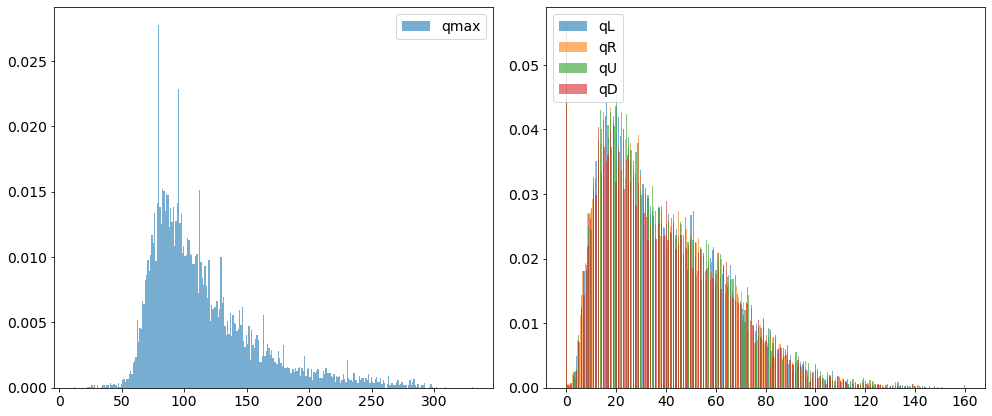

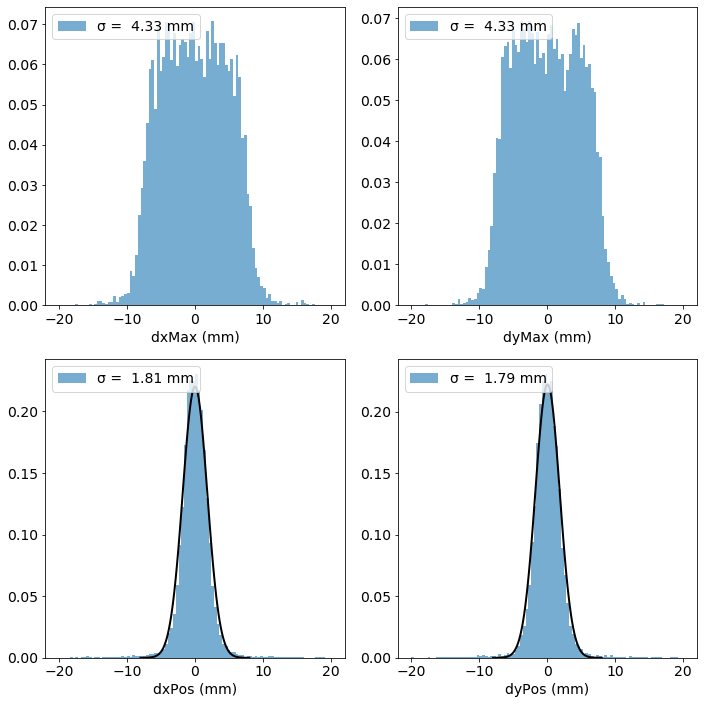

In [161]:
q_sipm(krdst,  bins=300, figsize=(14,6), alpha=0.6)
kr_point_resolution2(krdst, xlim=(-8,8), bins=100, figsize=(10,10))

#### Resolution is 1.8 mm (nominal at 6 mm mask is 1.6 mm)

### PDE = 0.4, th = 5 pes

In [164]:
setup = Setup(sipmPDE    = 0.4,
              maskPDE    = 1.0,
              qTh        = 5.0,
              tpConfig   = "FLEX100_M8_O6_EL8bar")
ofile_name = f"{setup.name}.csv"
ofile = f"{ofile_path}/{ofile_name}"
print(f" dst name = {ofile}")
krdst = pd.read_csv(ofile)

 dst name = /Users/jj/Development/flexdata/kdsts/FLEX100_M8_O6_EL8bar_PMTs_sipmPDE_0.4_maskPDE_1.0_qTh_5.0.csv


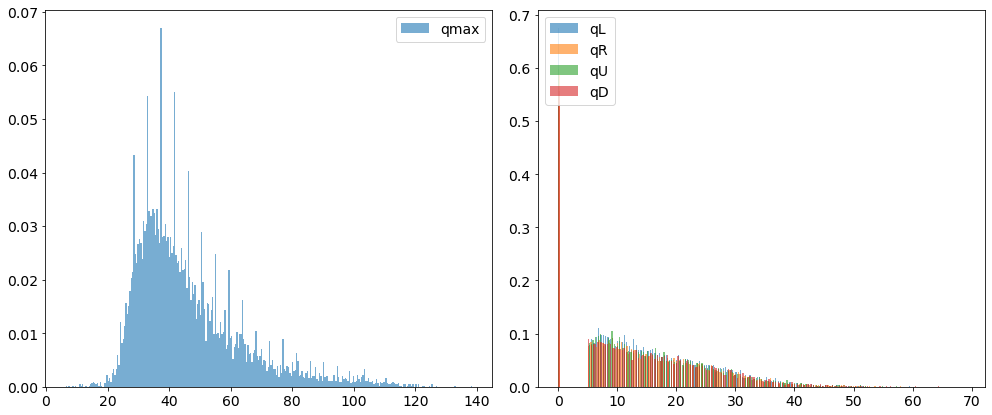

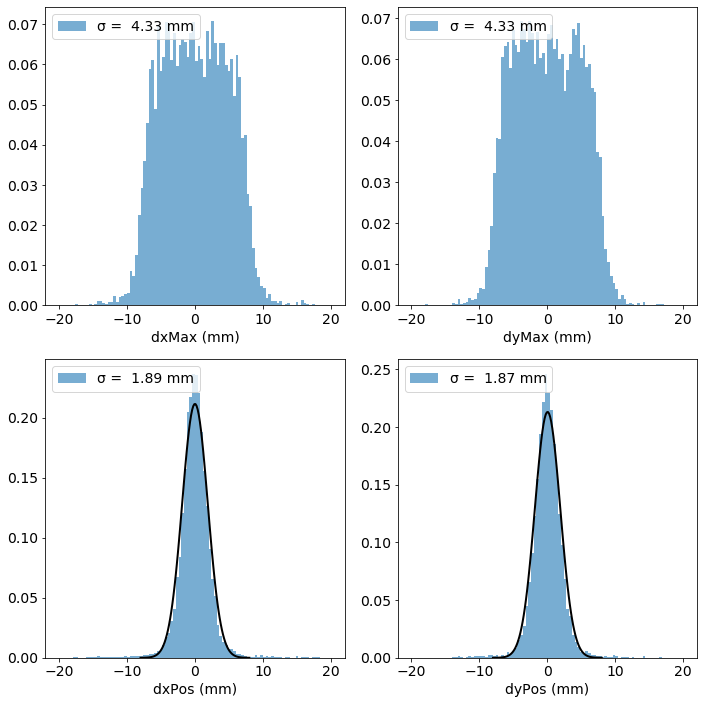

In [165]:
q_sipm(krdst,  bins=300, figsize=(14,6), alpha=0.6)
kr_point_resolution2(krdst, xlim=(-8,8), bins=100, figsize=(10,10))

#### Resolution with PDE (and Thr) 1.9 mm, similar to case 6 mm

### PDE = 0.4 mask PDE = 0.4, th = 1 pes

In [166]:
setup = Setup(sipmPDE    = 0.4,
              maskPDE    = 0.4,
              qTh        = 1.0,
              tpConfig   = "FLEX100_M8_O6_EL8bar")
ofile_name = f"{setup.name}.csv"
ofile = f"{ofile_path}/{ofile_name}"
print(f" dst name = {ofile}")
krdst = pd.read_csv(ofile)

 dst name = /Users/jj/Development/flexdata/kdsts/FLEX100_M8_O6_EL8bar_PMTs_sipmPDE_0.4_maskPDE_0.4_qTh_1.0.csv


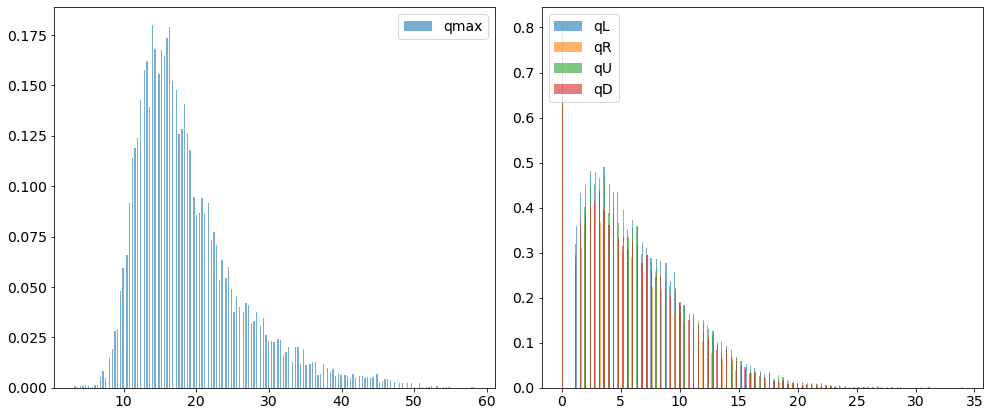

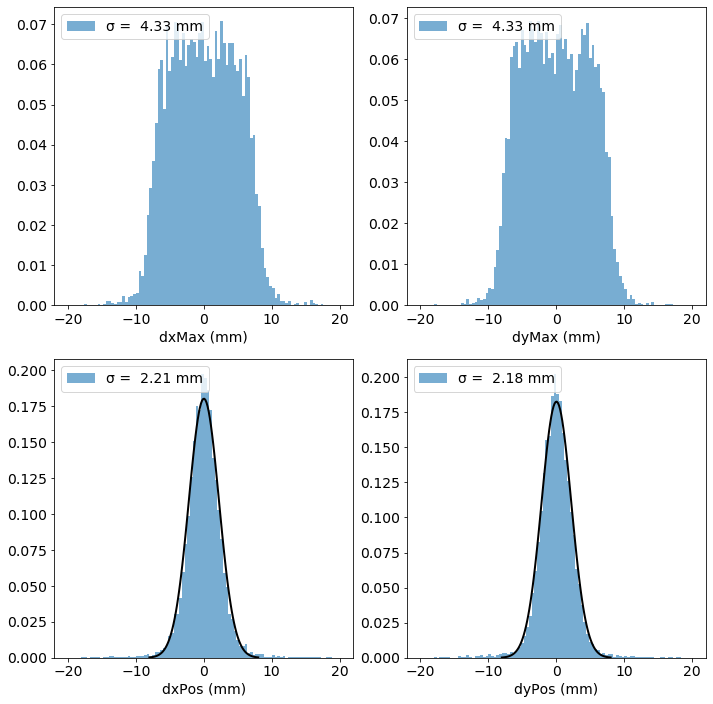

In [167]:
q_sipm(krdst,  bins=300, figsize=(14,6), alpha=0.6)
kr_point_resolution2(krdst, xlim=(-8,8), bins=100, figsize=(10,10))

#### Resolution 2.2 mm, similar to 6 mm case 

## FLEX100_M4_O6_EL8bar and FLEX100_M2_O6_EL8bar

### Nominal FLEX100_M4_O6_EL8bar

In [207]:
setup = Setup(sipmPDE    = 0.4,
              maskPDE    = 0.4,
              qTh        = 1.0,
              tpConfig   = "FLEX100_M4_O6_EL8bar")
ofile_name = f"{setup.name}.csv"
ofile = f"{ofile_path}/{ofile_name}"
print(f" dst name = {ofile}")
krdst = pd.read_csv(ofile)

 dst name = /Users/jj/Development/flexdata/kdsts/FLEX100_M4_O6_EL8bar_PMTs_sipmPDE_0.4_maskPDE_0.4_qTh_1.0.csv


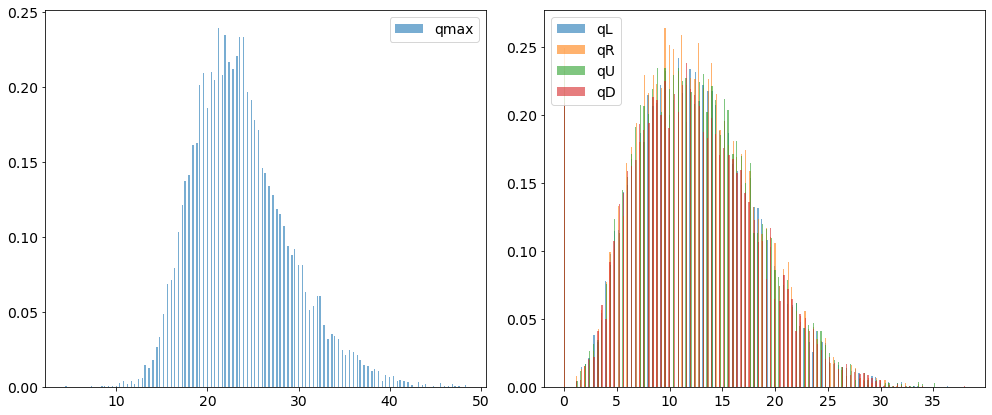

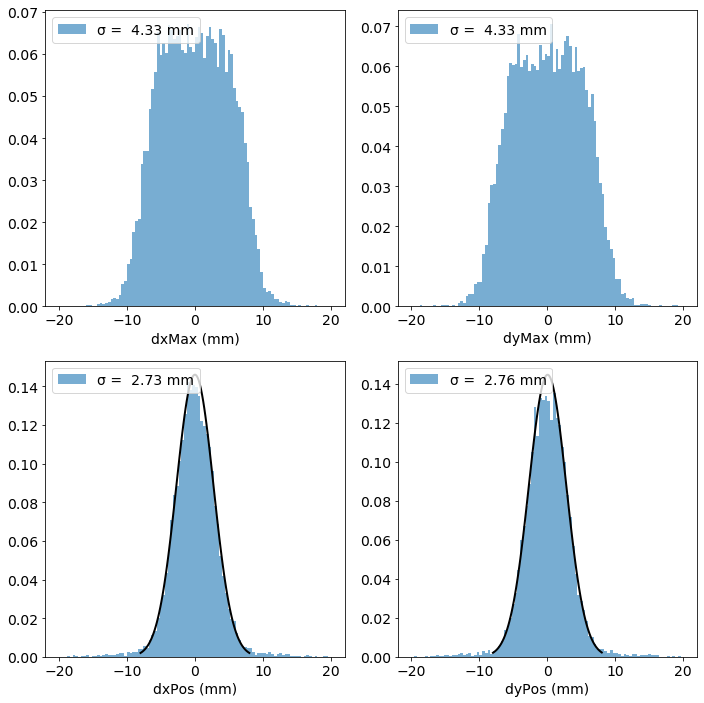

In [208]:
q_sipm(krdst,  bins=300, figsize=(14,6), alpha=0.6)
kr_point_resolution2(krdst, xlim=(-8,8), bins=100, figsize=(10,10))

#### Resolution spoils w.r.t 6 mm!

### Nominal FLEX100_M2_O6_EL8bar

In [186]:
setup = Setup(sipmPDE    = 1.0,
              maskPDE    = 1.0,
              qTh        = 0.0,
              tpConfig   = "FLEX100_M2_O6_EL8bar")
ofile_name = f"{setup.name}.csv"
ofile = f"{ofile_path}/{ofile_name}"
print(f" dst name = {ofile}")
krdst = pd.read_csv(ofile)

 dst name = /Users/jj/Development/flexdata/kdsts/FLEX100_M2_O6_EL8bar_PMTs_sipmPDE_1.0_maskPDE_1.0_qTh_0.0.csv


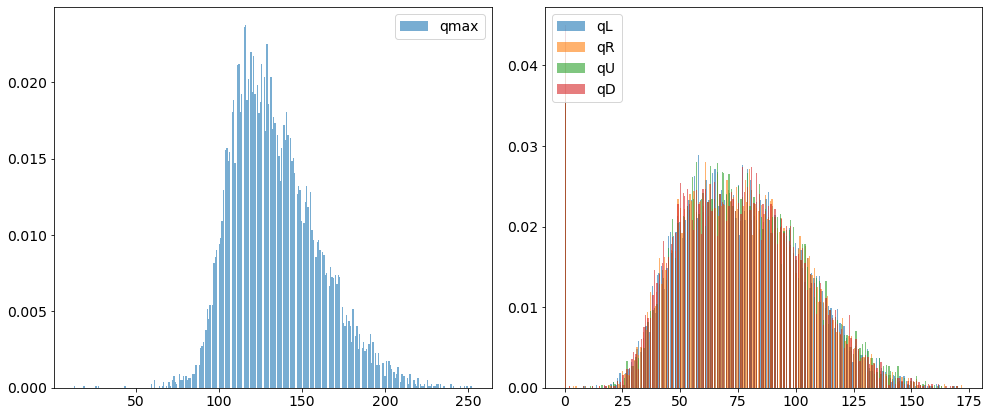

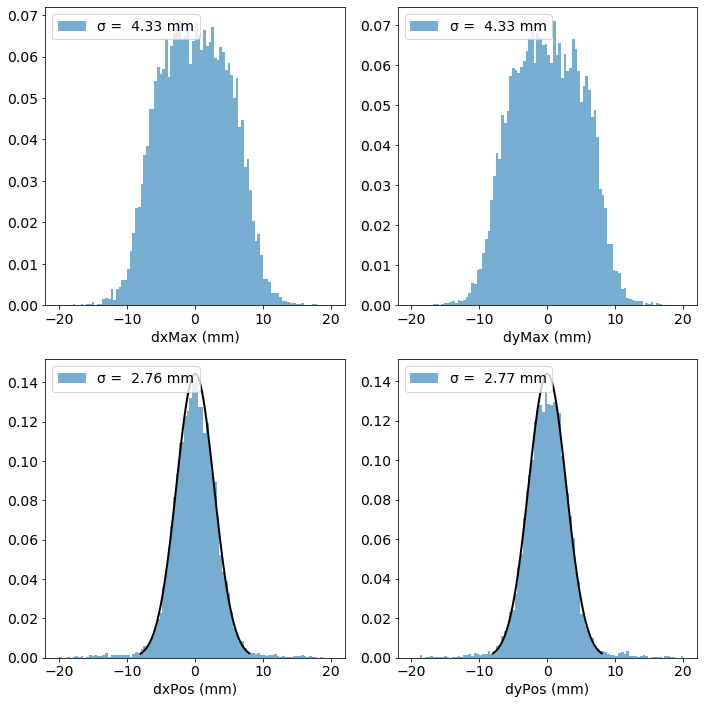

In [187]:
q_sipm(krdst,  bins=300, figsize=(14,6), alpha=0.6)
kr_point_resolution2(krdst, xlim=(-8,8), bins=100, figsize=(10,10))

#### Resolution further deteriorates 

## FLEX100_M6_O4_EL8bar and FLEX100_M6_O8_EL8bar

### FLEX100_M6_O4_EL8bar

In [202]:
setup = Setup(sipmPDE    = 0.4,
              maskPDE    = 0.4,
              qTh        = 1.0,
              tpConfig   = "FLEX100_M6_O4_EL8bar")
ofile_name = f"{setup.name}.csv"
ofile = f"{ofile_path}/{ofile_name}"
print(f" dst name = {ofile}")
krdst = pd.read_csv(ofile)

 dst name = /Users/jj/Development/flexdata/kdsts/FLEX100_M6_O4_EL8bar_PMTs_sipmPDE_0.4_maskPDE_0.4_qTh_1.0.csv


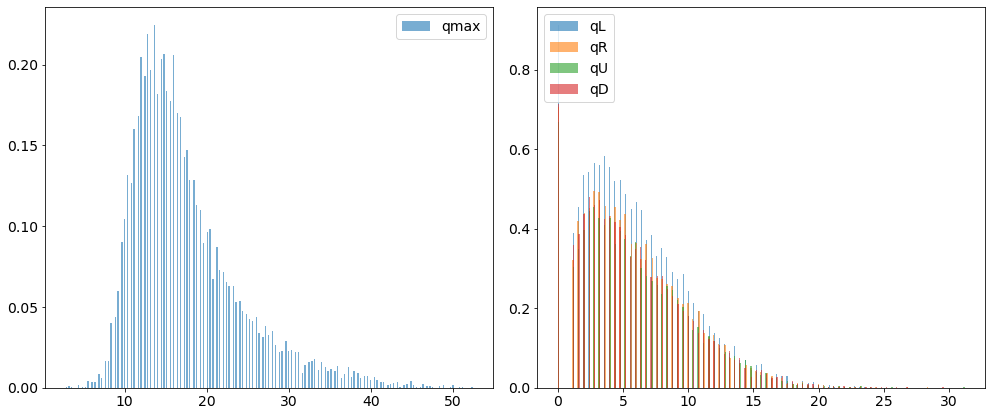

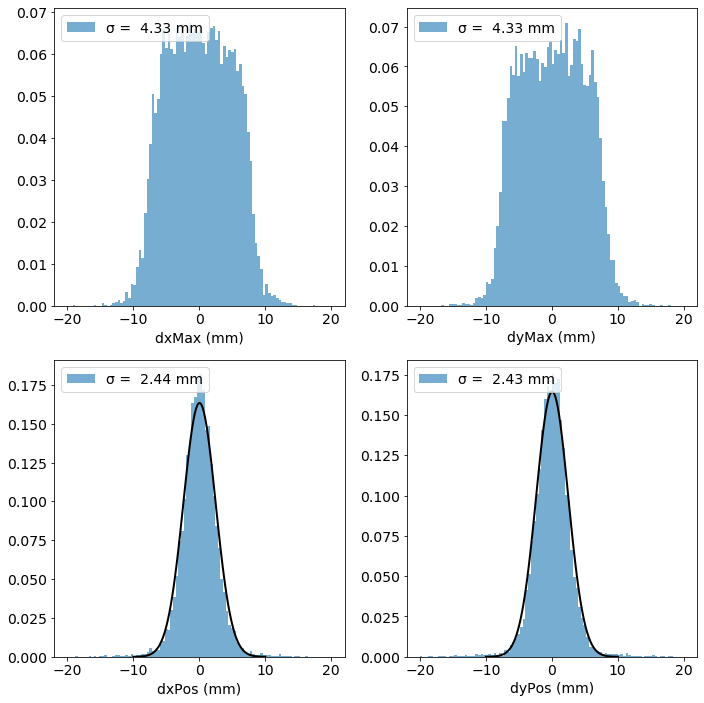

In [204]:
q_sipm(krdst,  bins=300, figsize=(14,6), alpha=0.6)
kr_point_resolution2(krdst, xlim=(-10,10), bins=100, figsize=(10,10))

### FLEX100_M6_O8_EL8bar

In [205]:
setup = Setup(sipmPDE    = 0.4,
              maskPDE    = 0.4,
              qTh        = 1.0,
              tpConfig   = "FLEX100_M6_O8_EL8bar")
ofile_name = f"{setup.name}.csv"
ofile = f"{ofile_path}/{ofile_name}"
print(f" dst name = {ofile}")
krdst = pd.read_csv(ofile)

 dst name = /Users/jj/Development/flexdata/kdsts/FLEX100_M6_O8_EL8bar_PMTs_sipmPDE_0.4_maskPDE_0.4_qTh_1.0.csv


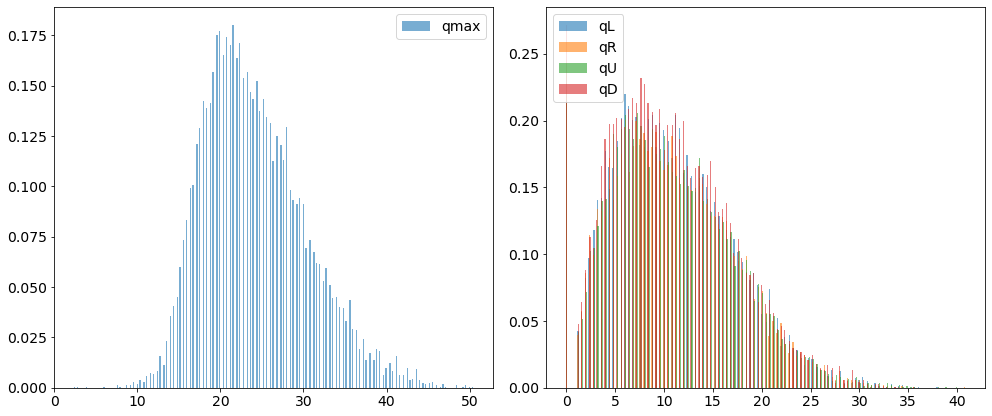

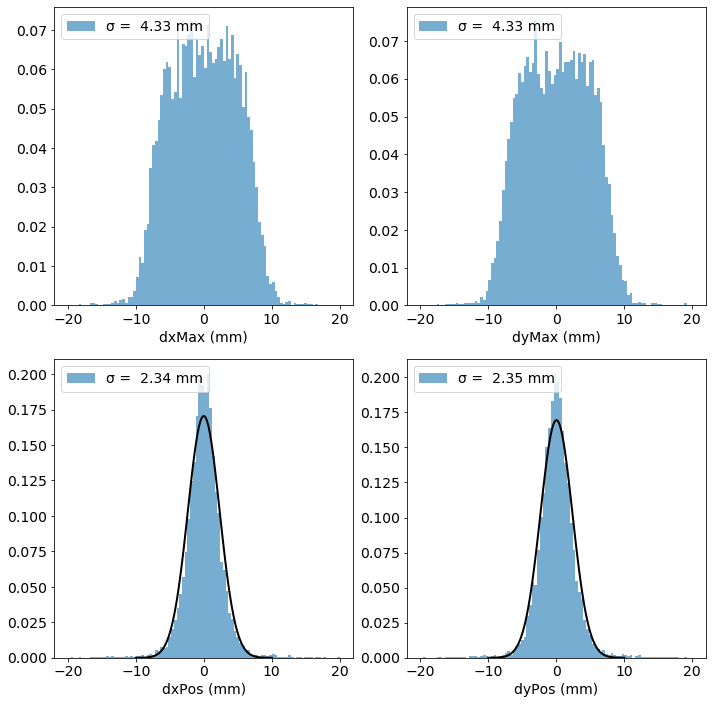

In [206]:
q_sipm(krdst,  bins=300, figsize=(14,6), alpha=0.6)
kr_point_resolution2(krdst, xlim=(-10,10), bins=100, figsize=(10,10))

## The close TP case: FLEX100_D3_M2_O6_EL8bar

In [188]:
setup = Setup(sipmPDE    = 1.0,
              maskPDE    = 1.0,
              qTh        = 0.0,
              tpConfig   = "FLEX100_D3_M2_O6_EL8bar")
ofile_name = f"{setup.name}.csv"
ofile = f"{ofile_path}/{ofile_name}"
print(f" dst name = {ofile}")
krdst = pd.read_csv(ofile) 

 dst name = /Users/jj/Development/flexdata/kdsts/FLEX100_D3_M2_O6_EL8bar_PMTs_sipmPDE_1.0_maskPDE_1.0_qTh_0.0.csv


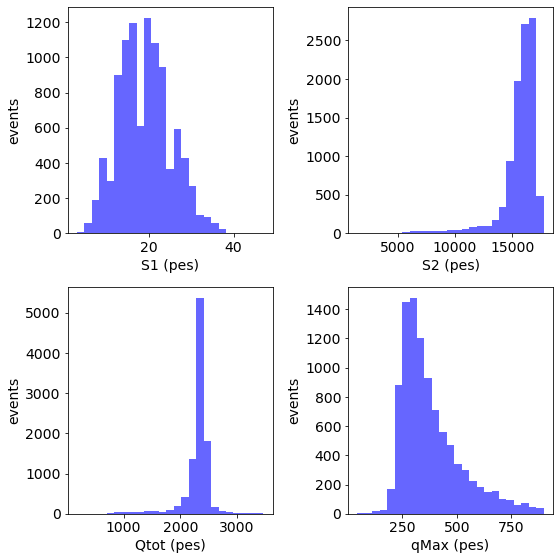

In [193]:
histos_df(krdst, 
          vars    = ('S1e','S2e','Qtot','qMax'), 
          varmins = [0,0,0, 0], 
          varmaxs = [50,25000,3500,900], 
          xlabels = ['S1 (pes)','S2 (pes)','Qtot (pes)','qMax (pes)'], 
          ylabels = 4 * ['events'], 
          bins    = 4 * [25],
          alphas  = 4 * [0.6],
          colors  = 4 * ['b'],
          splt    = (2,2), 
          figsize = (8,8))

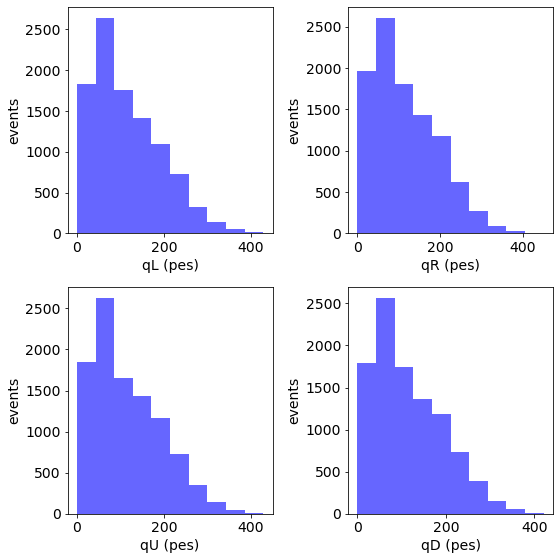

In [195]:
histos_df(krdst, 
          vars    = ('qL','qR','qU','qD'), 
          varmins = 4 * [0], 
          varmaxs = 4 * [500], 
          xlabels = ['qL (pes)','qR (pes)','qU (pes)','qD (pes)'], 
          ylabels = 4 * ['events'], 
          bins    = 4 * [10],
          alphas  = 4 * [0.6],
          colors  = 4 * ['b'],
          splt    = (2,2), 
          figsize = (8,8))

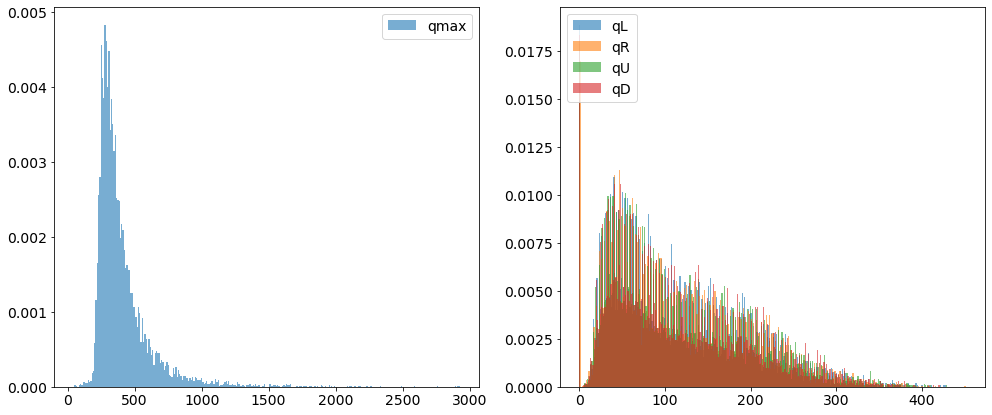

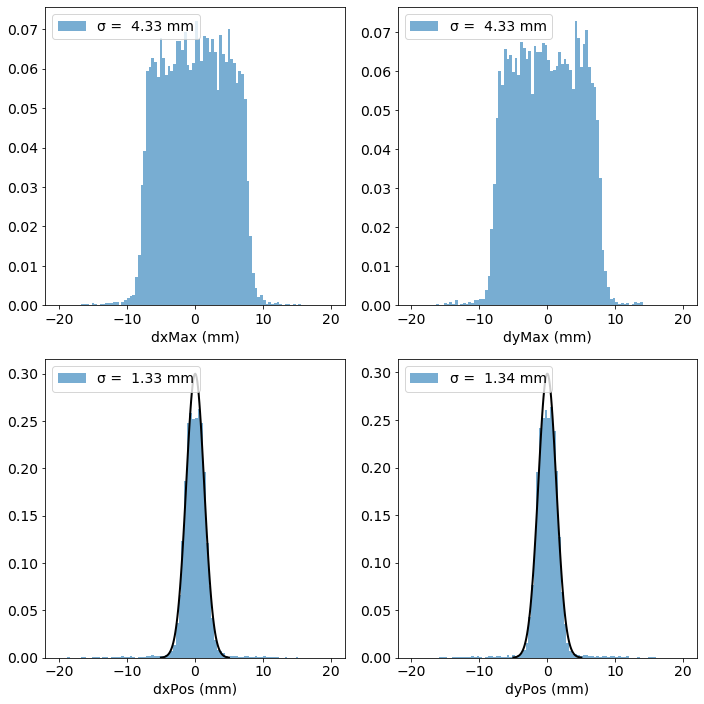

In [197]:
q_sipm(krdst,  bins=300, figsize=(14,6), alpha=0.6)
kr_point_resolution2(krdst, xlim=(-5,5), bins=100, figsize=(10,10))

In [198]:
setup = Setup(sipmPDE    = 0.4,
              maskPDE    = 1.0,
              qTh        = 1.0,
              tpConfig   = "FLEX100_D3_M2_O6_EL8bar")
ofile_name = f"{setup.name}.csv"
ofile = f"{ofile_path}/{ofile_name}"
print(f" dst name = {ofile}")
krdst = pd.read_csv(ofile) 

 dst name = /Users/jj/Development/flexdata/kdsts/FLEX100_D3_M2_O6_EL8bar_PMTs_sipmPDE_0.4_maskPDE_1.0_qTh_1.0.csv


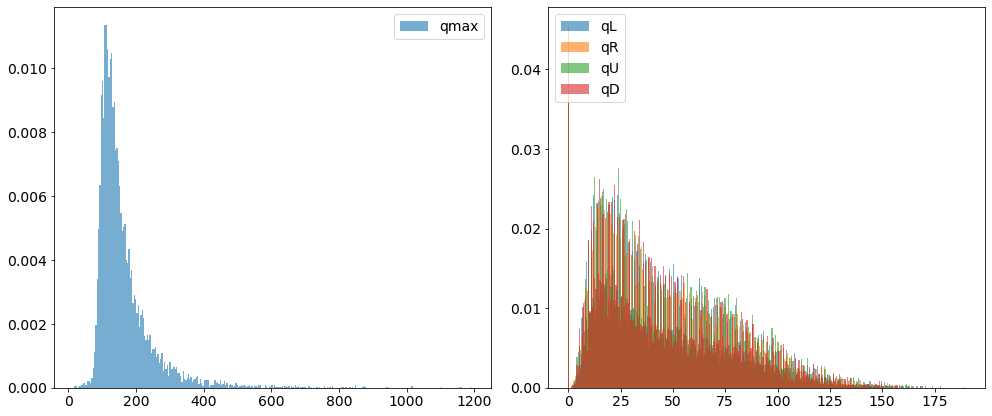

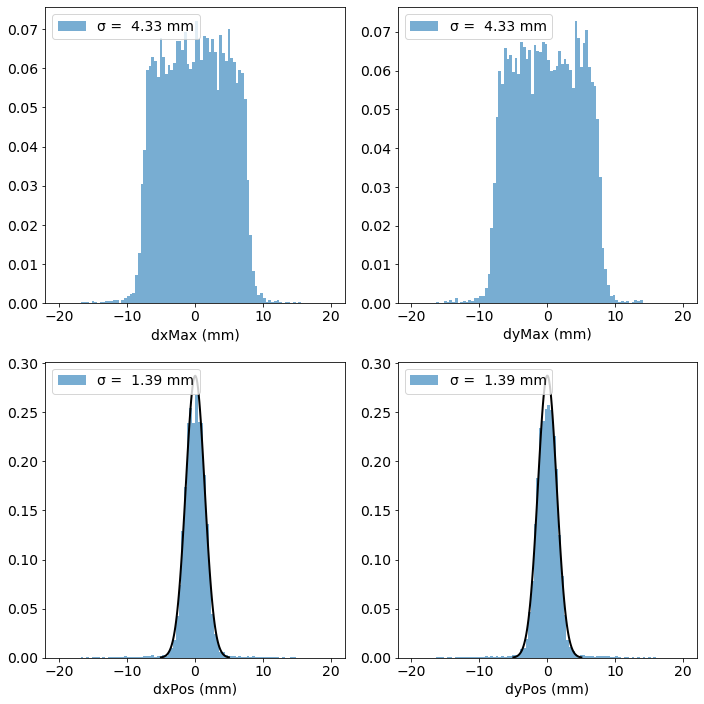

In [199]:
q_sipm(krdst,  bins=300, figsize=(14,6), alpha=0.6)
kr_point_resolution2(krdst, xlim=(-5,5), bins=100, figsize=(10,10))

In [200]:
setup = Setup(sipmPDE    = 0.4,
              maskPDE    = 0.4,
              qTh        = 1.0,
              tpConfig   = "FLEX100_D3_M2_O6_EL8bar")
ofile_name = f"{setup.name}.csv"
ofile = f"{ofile_path}/{ofile_name}"
print(f" dst name = {ofile}")
krdst = pd.read_csv(ofile) 

 dst name = /Users/jj/Development/flexdata/kdsts/FLEX100_D3_M2_O6_EL8bar_PMTs_sipmPDE_0.4_maskPDE_0.4_qTh_1.0.csv


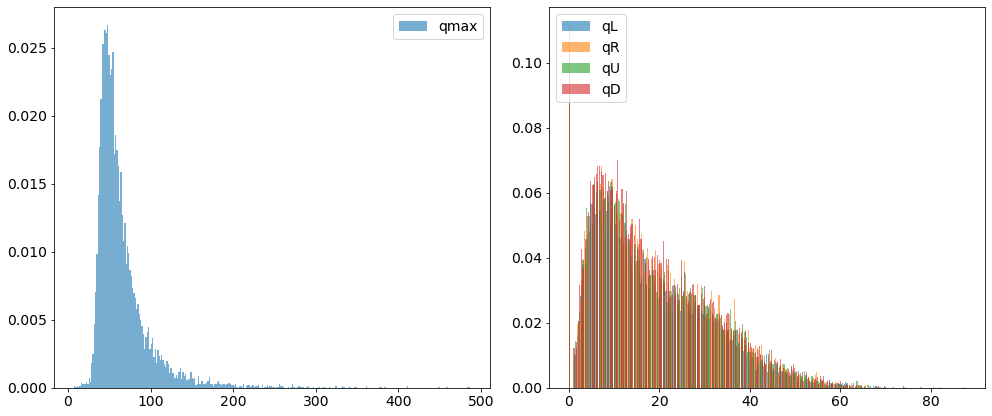

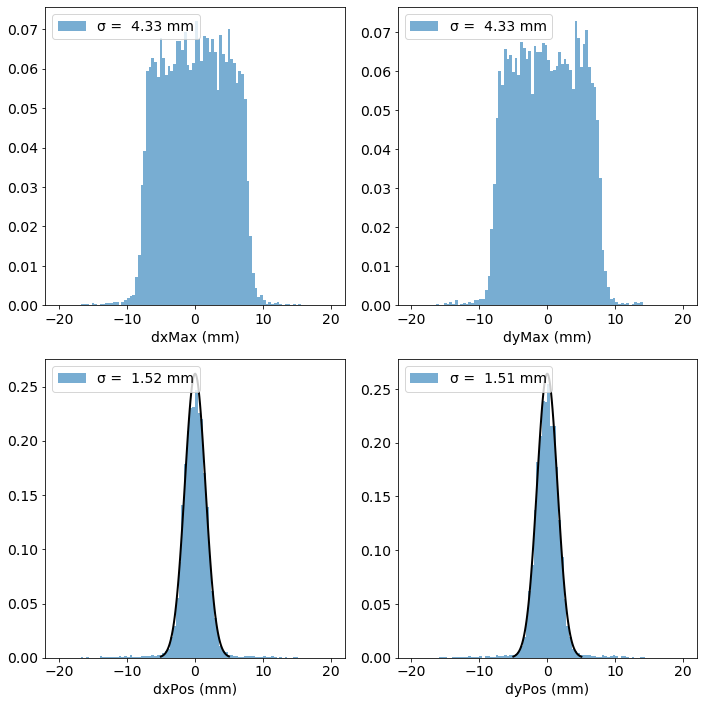

In [201]:
q_sipm(krdst,  bins=300, figsize=(14,6), alpha=0.6)
kr_point_resolution2(krdst, xlim=(-5,5), bins=100, figsize=(10,10))

## Pitch of 10 mm 

### At 15 mm distance, standard M606 mask 

In [209]:
setup = Setup(flexDATA   = FDATA,
                  sipmPDE    = 1.0,
                  maskPDE    = 1.0,
                  qTh        = 0.0,
                  tpConfig   = "FLEX100_M6_O6_P10.EL8bar")
print(setup)


        Setup <FLEX100_M6_O6_P10.EL8bar_PMTs_sipmPDE_1.0_maskPDE_1.0_qTh_0.0>:
        tracking plane configuration = FLEX100_M6_O6_P10.EL8bar
        sipm PDE                     = 1.0
        transmission of teflon masks = 1.0
        charge threshold             = 0.0
        energy sensors               = PMTs
        pitch                        = 10.0
        number of energy sensors     = 60
        number of SiPMs              = 7484
        root directory               = /Users/jj/Development/flexdata/FLEX100_M6_O6_P10.EL8bar
        number of h5 files in dir    = 100
        sipm map at                  = /Users/jj/Development/flexdata/flexmaps/sipm_map_10.0_mm.csv
        sipm map name                = sipm_map_10.0_mm.csv
        output file                  = /Users/jj/Development/flexdata/kdsts/FLEX100_M6_O6_P10.EL8bar_PMTs_sipmPDE_1.0_maskPDE_1.0_qTh_0.0.csv
        


In [210]:
ofile_name = f"{setup.name}.csv"
ofile = f"{ofile_path}/{ofile_name}"
print(f" dst name = {ofile}")
krdst = pd.read_csv(ofile) 

 dst name = /Users/jj/Development/flexdata/kdsts/FLEX100_M6_O6_P10.EL8bar_PMTs_sipmPDE_1.0_maskPDE_1.0_qTh_0.0.csv


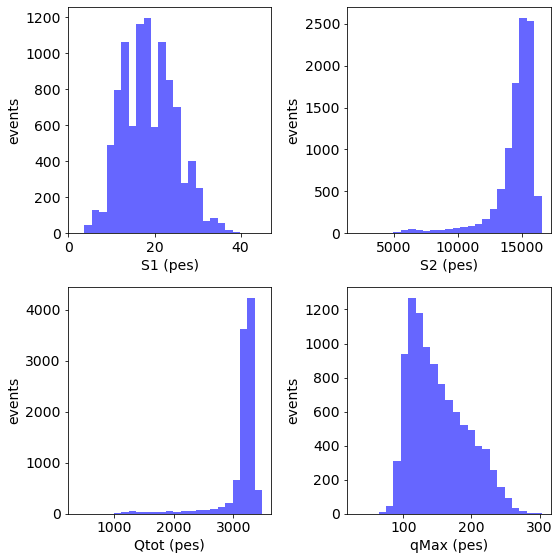

In [211]:
histos_df(krdst, 
          vars    = ('S1e','S2e','Qtot','qMax'), 
          varmins = [0,0,0, 0], 
          varmaxs = [50,25000,3500,900], 
          xlabels = ['S1 (pes)','S2 (pes)','Qtot (pes)','qMax (pes)'], 
          ylabels = 4 * ['events'], 
          bins    = 4 * [25],
          alphas  = 4 * [0.6],
          colors  = 4 * ['b'],
          splt    = (2,2), 
          figsize = (8,8))

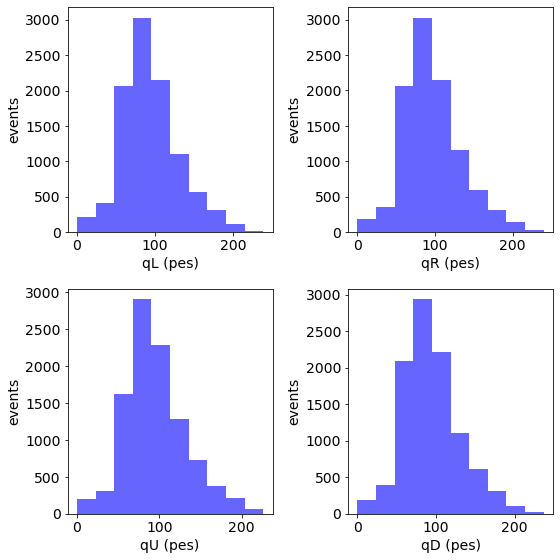

In [212]:
histos_df(krdst, 
          vars    = ('qL','qR','qU','qD'), 
          varmins = 4 * [0], 
          varmaxs = 4 * [500], 
          xlabels = ['qL (pes)','qR (pes)','qU (pes)','qD (pes)'], 
          ylabels = 4 * ['events'], 
          bins    = 4 * [10],
          alphas  = 4 * [0.6],
          colors  = 4 * ['b'],
          splt    = (2,2), 
          figsize = (8,8))

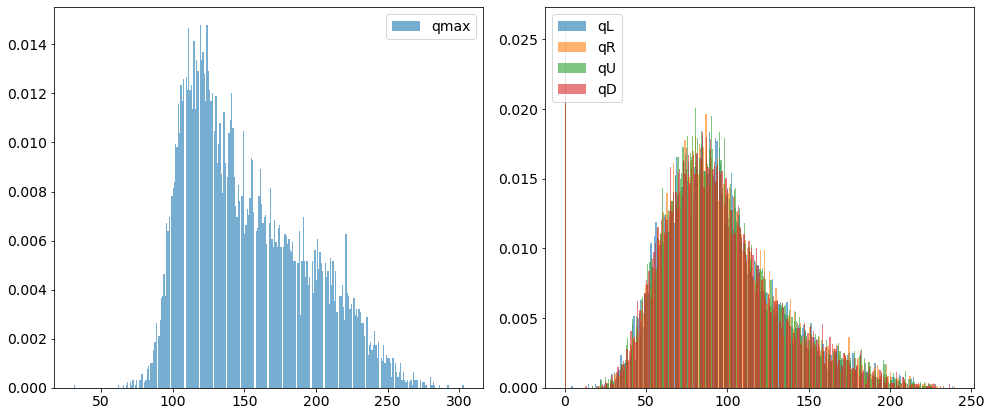

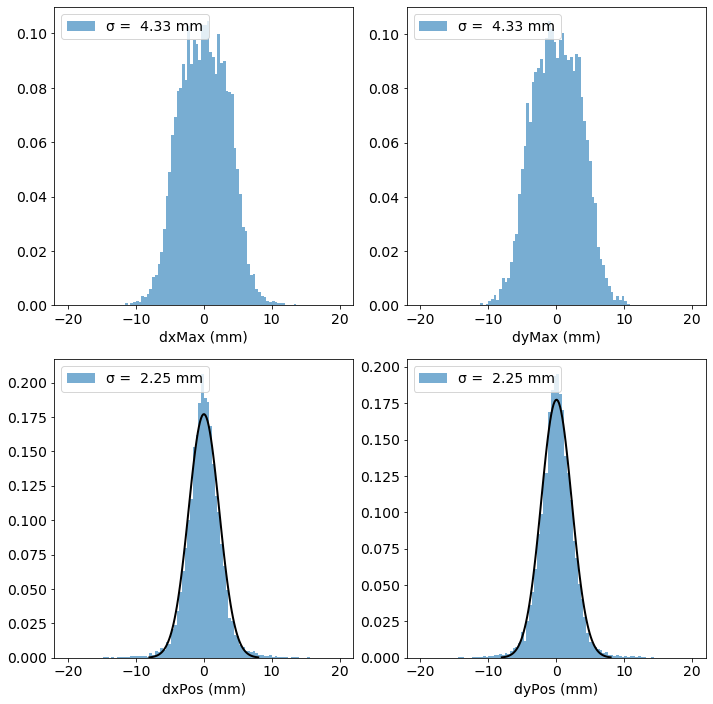

In [214]:
q_sipm(krdst,  bins=300, figsize=(14,6), alpha=0.6)
kr_point_resolution2(krdst, xlim=(-8,8), bins=100, figsize=(10,10))

#### Not as good as the resolution with 15 mm pitch possibly due to not optimised mask

### At 3 mm distance

In [215]:
setup = Setup(flexDATA   = FDATA,
                  sipmPDE    = 1.0,
                  maskPDE    = 1.0,
                  qTh        = 0.0,
                  tpConfig   = "FLEX100_D3_M2_O6_P10.EL8bar")
print(setup)


        Setup <FLEX100_D3_M2_O6_P10.EL8bar_PMTs_sipmPDE_1.0_maskPDE_1.0_qTh_0.0>:
        tracking plane configuration = FLEX100_D3_M2_O6_P10.EL8bar
        sipm PDE                     = 1.0
        transmission of teflon masks = 1.0
        charge threshold             = 0.0
        energy sensors               = PMTs
        pitch                        = 10.0
        number of energy sensors     = 60
        number of SiPMs              = 7484
        root directory               = /Users/jj/Development/flexdata/FLEX100_D3_M2_O6_P10.EL8bar
        number of h5 files in dir    = 100
        sipm map at                  = /Users/jj/Development/flexdata/flexmaps/sipm_map_10.0_mm.csv
        sipm map name                = sipm_map_10.0_mm.csv
        output file                  = /Users/jj/Development/flexdata/kdsts/FLEX100_D3_M2_O6_P10.EL8bar_PMTs_sipmPDE_1.0_maskPDE_1.0_qTh_0.0.csv
        


In [216]:
ofile_name = f"{setup.name}.csv"
ofile = f"{ofile_path}/{ofile_name}"
print(f" dst name = {ofile}")
krdst = pd.read_csv(ofile) 

 dst name = /Users/jj/Development/flexdata/kdsts/FLEX100_D3_M2_O6_P10.EL8bar_PMTs_sipmPDE_1.0_maskPDE_1.0_qTh_0.0.csv


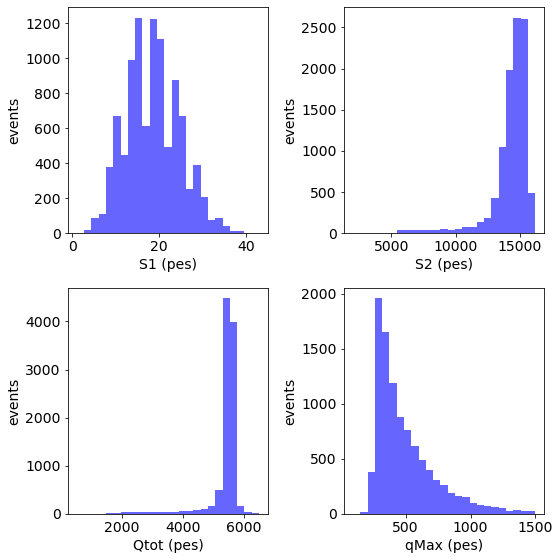

In [220]:
histos_df(krdst, 
          vars    = ('S1e','S2e','Qtot','qMax'), 
          varmins = [0,0,0, 0], 
          varmaxs = [50,25000,6500,1500], 
          xlabels = ['S1 (pes)','S2 (pes)','Qtot (pes)','qMax (pes)'], 
          ylabels = 4 * ['events'], 
          bins    = 4 * [25],
          alphas  = 4 * [0.6],
          colors  = 4 * ['b'],
          splt    = (2,2), 
          figsize = (8,8))

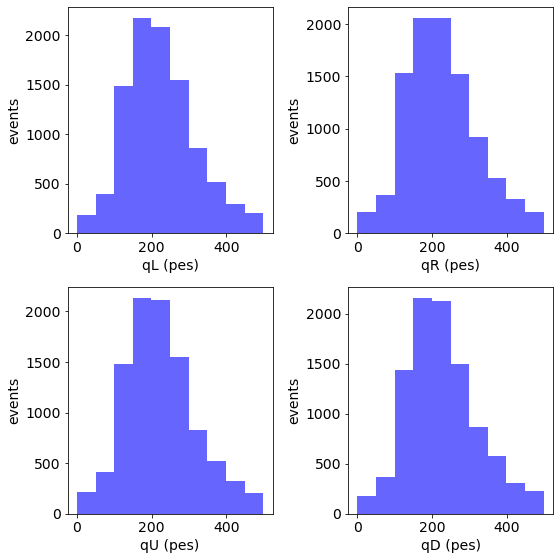

In [221]:
histos_df(krdst, 
          vars    = ('qL','qR','qU','qD'), 
          varmins = 4 * [0], 
          varmaxs = 4 * [500], 
          xlabels = ['qL (pes)','qR (pes)','qU (pes)','qD (pes)'], 
          ylabels = 4 * ['events'], 
          bins    = 4 * [10],
          alphas  = 4 * [0.6],
          colors  = 4 * ['b'],
          splt    = (2,2), 
          figsize = (8,8))

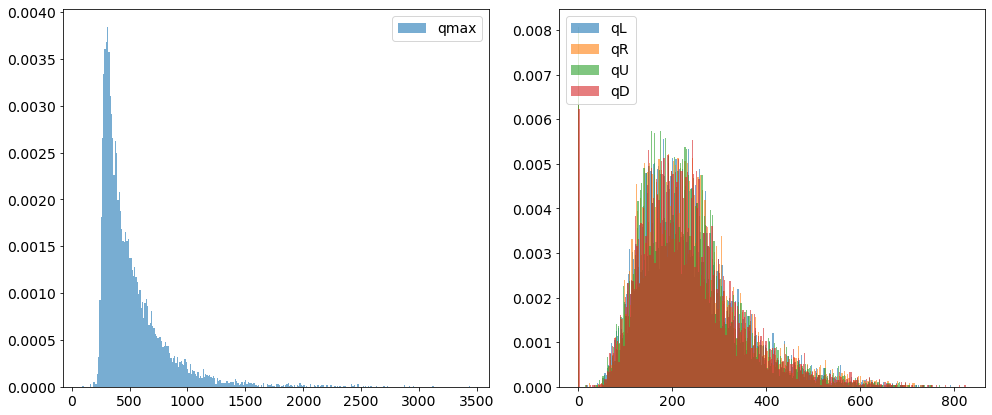

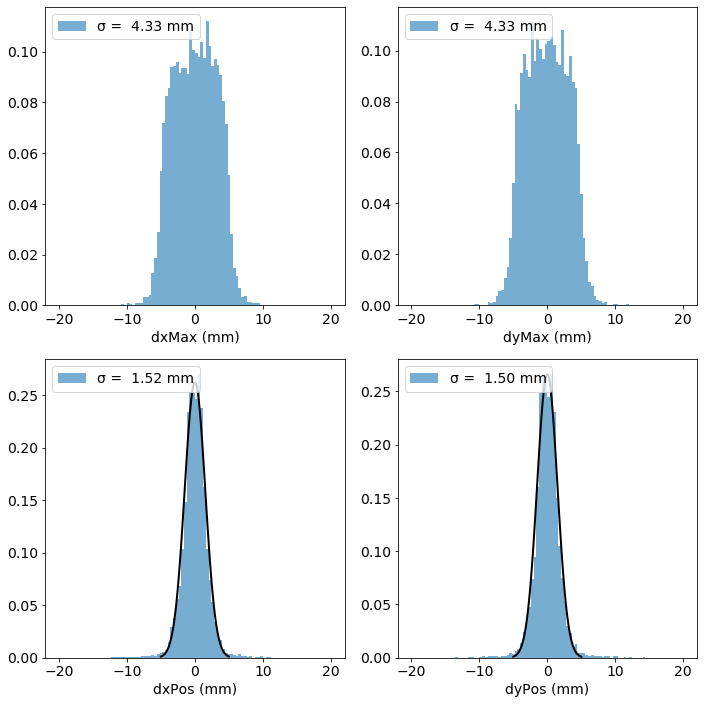

In [223]:
q_sipm(krdst,  bins=300, figsize=(14,6), alpha=0.6)
kr_point_resolution2(krdst, xlim=(-5,5), bins=100, figsize=(10,10))

### No improvement on resolution
- Pitch does not appear to be such a driving factor, at least in point resolution.
- Effects will be more dominated by diffusion and distance to the plane